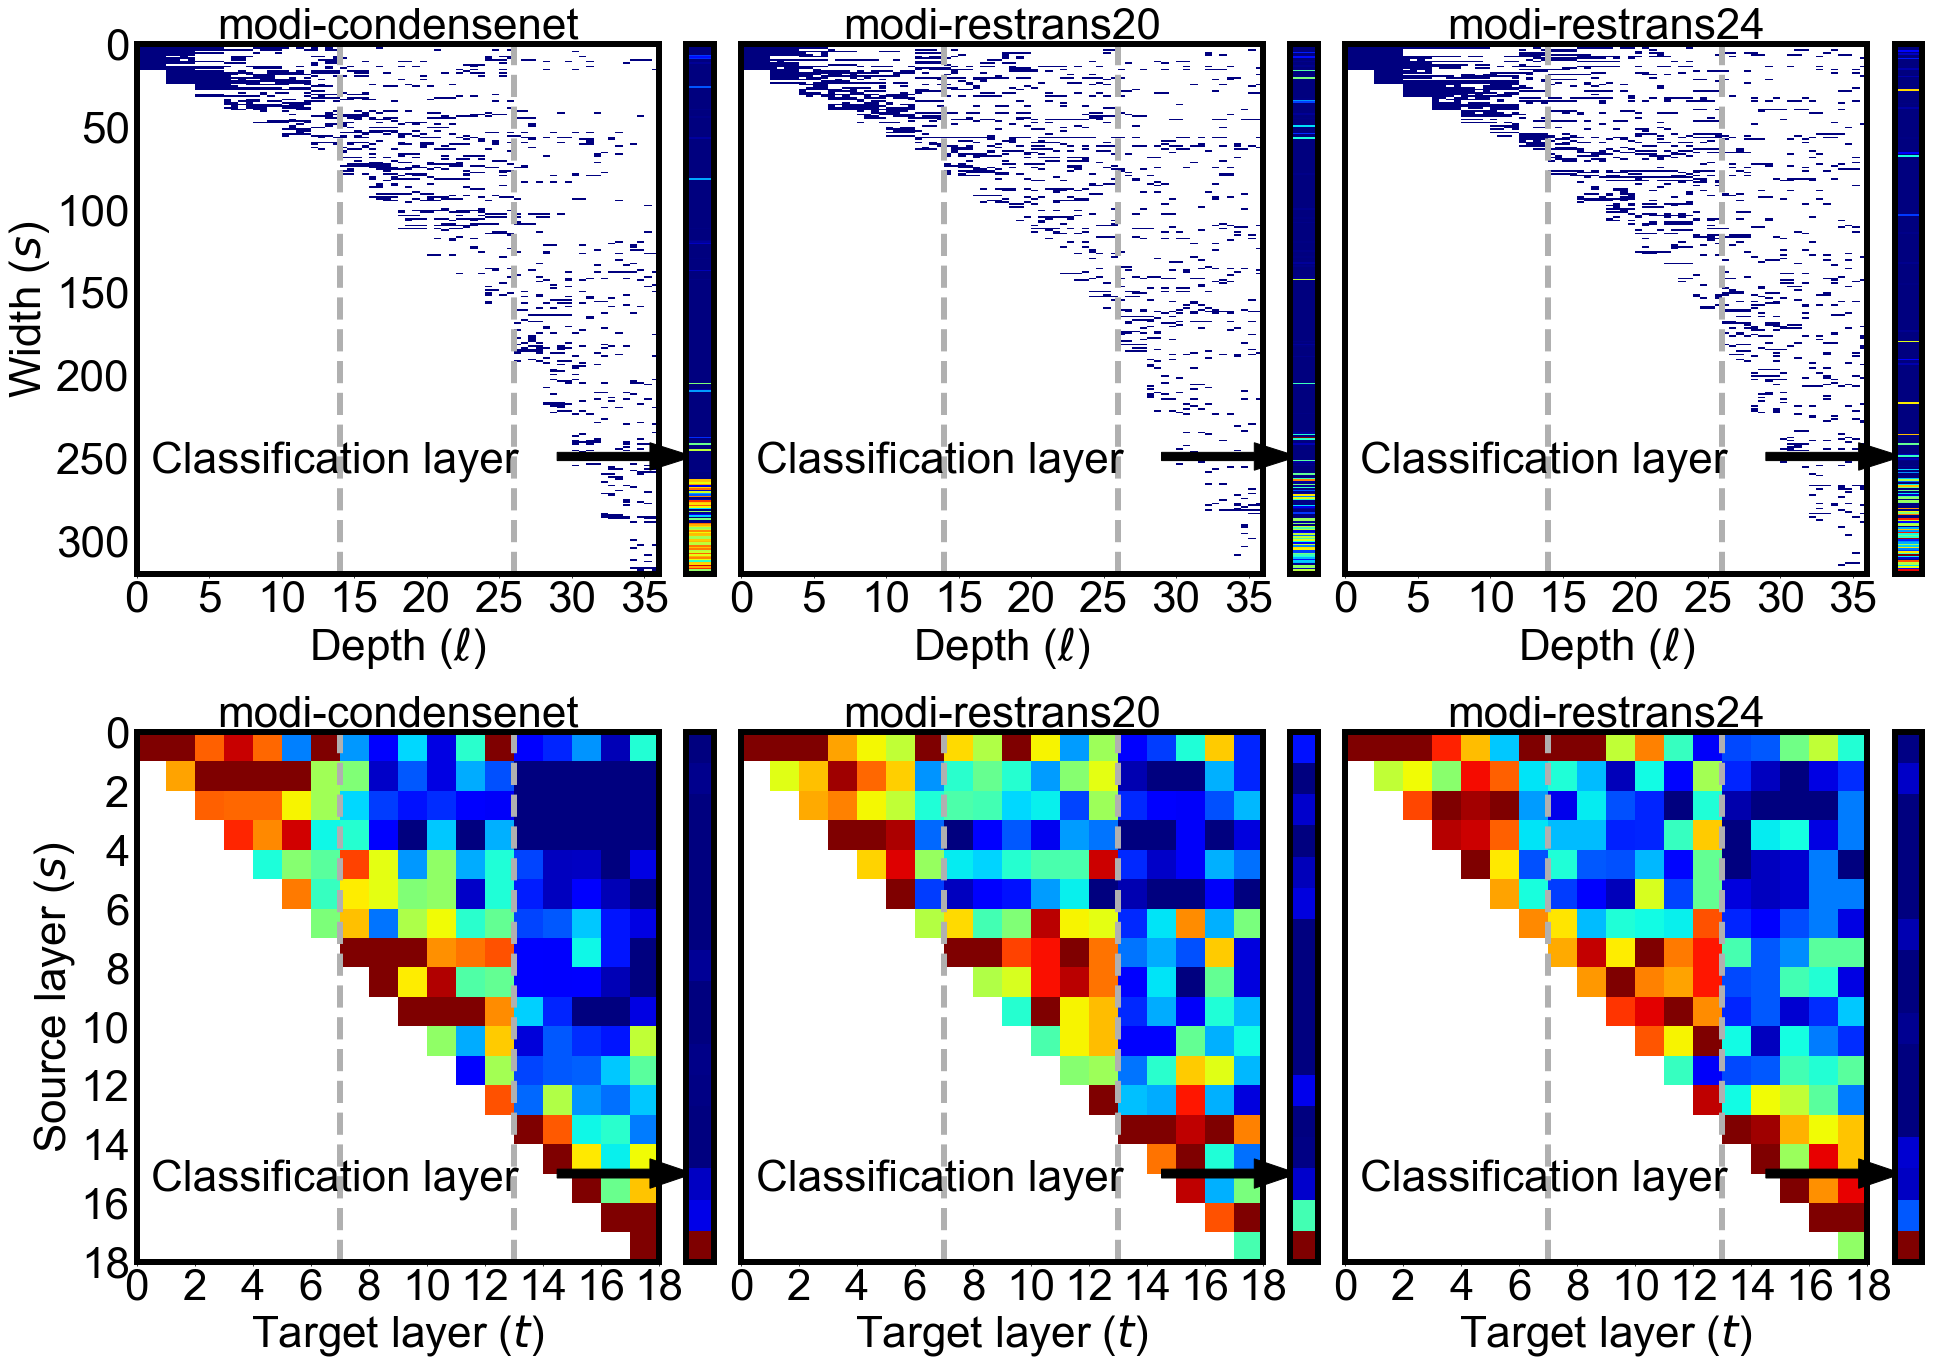

In [18]:
#LGC mask 

%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 33
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 3
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'modi\40_threshold20\save_models\model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold24\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
    if random != 0:
        all_masks = all_masks[1::2] 
        all_weights = all_weights[1::2] 
    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
    ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-1)//TOTAL)

    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))
    whole_mask = np.ma.masked_where(whole_mask==0, np.log(whole_mask+1))
    im = plt.imshow(whole_mask, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'modi-condensenet', size=FS*scale)
    elif random == 1:
        plt.title(r'modi-restrans20', size=FS*scale)
    else:
        plt.title(r'modi-restrans24', size=FS*scale)
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
    arrow = ax.arrow(14.5*2, 15*h_s, 3.2*2, 0.0, fc="k", ec="k",
        head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
    arrow.set_clip_on(False)
    ax.text(0.5*2, 15.6*h_s, "Classification layer", 
            fontsize=FS*scale)  
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-1)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'modi-condensenet', size=FS*scale)
    elif random == 1:
        plt.title(r'modi-restrans20', size=FS*scale)
    else:
        plt.title(r'modi-restrans24', size=FS*scale)
    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
    arrow = ax.arrow(14.5, 15, 3.2, 0.0, fc="k", ec="k",
        head_width=1., head_length=1.5, width=.3,)
    arrow.set_clip_on(False)
    ax.text(0.5, 15.6, "Classification layer", 
            fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(classifier, interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet', extent=[0, 1,
                                                  whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGC_mask_modi-condensenet_modi-restrans20_modi-restrans24.pdf', bbox_inches='tight', format='pdf')

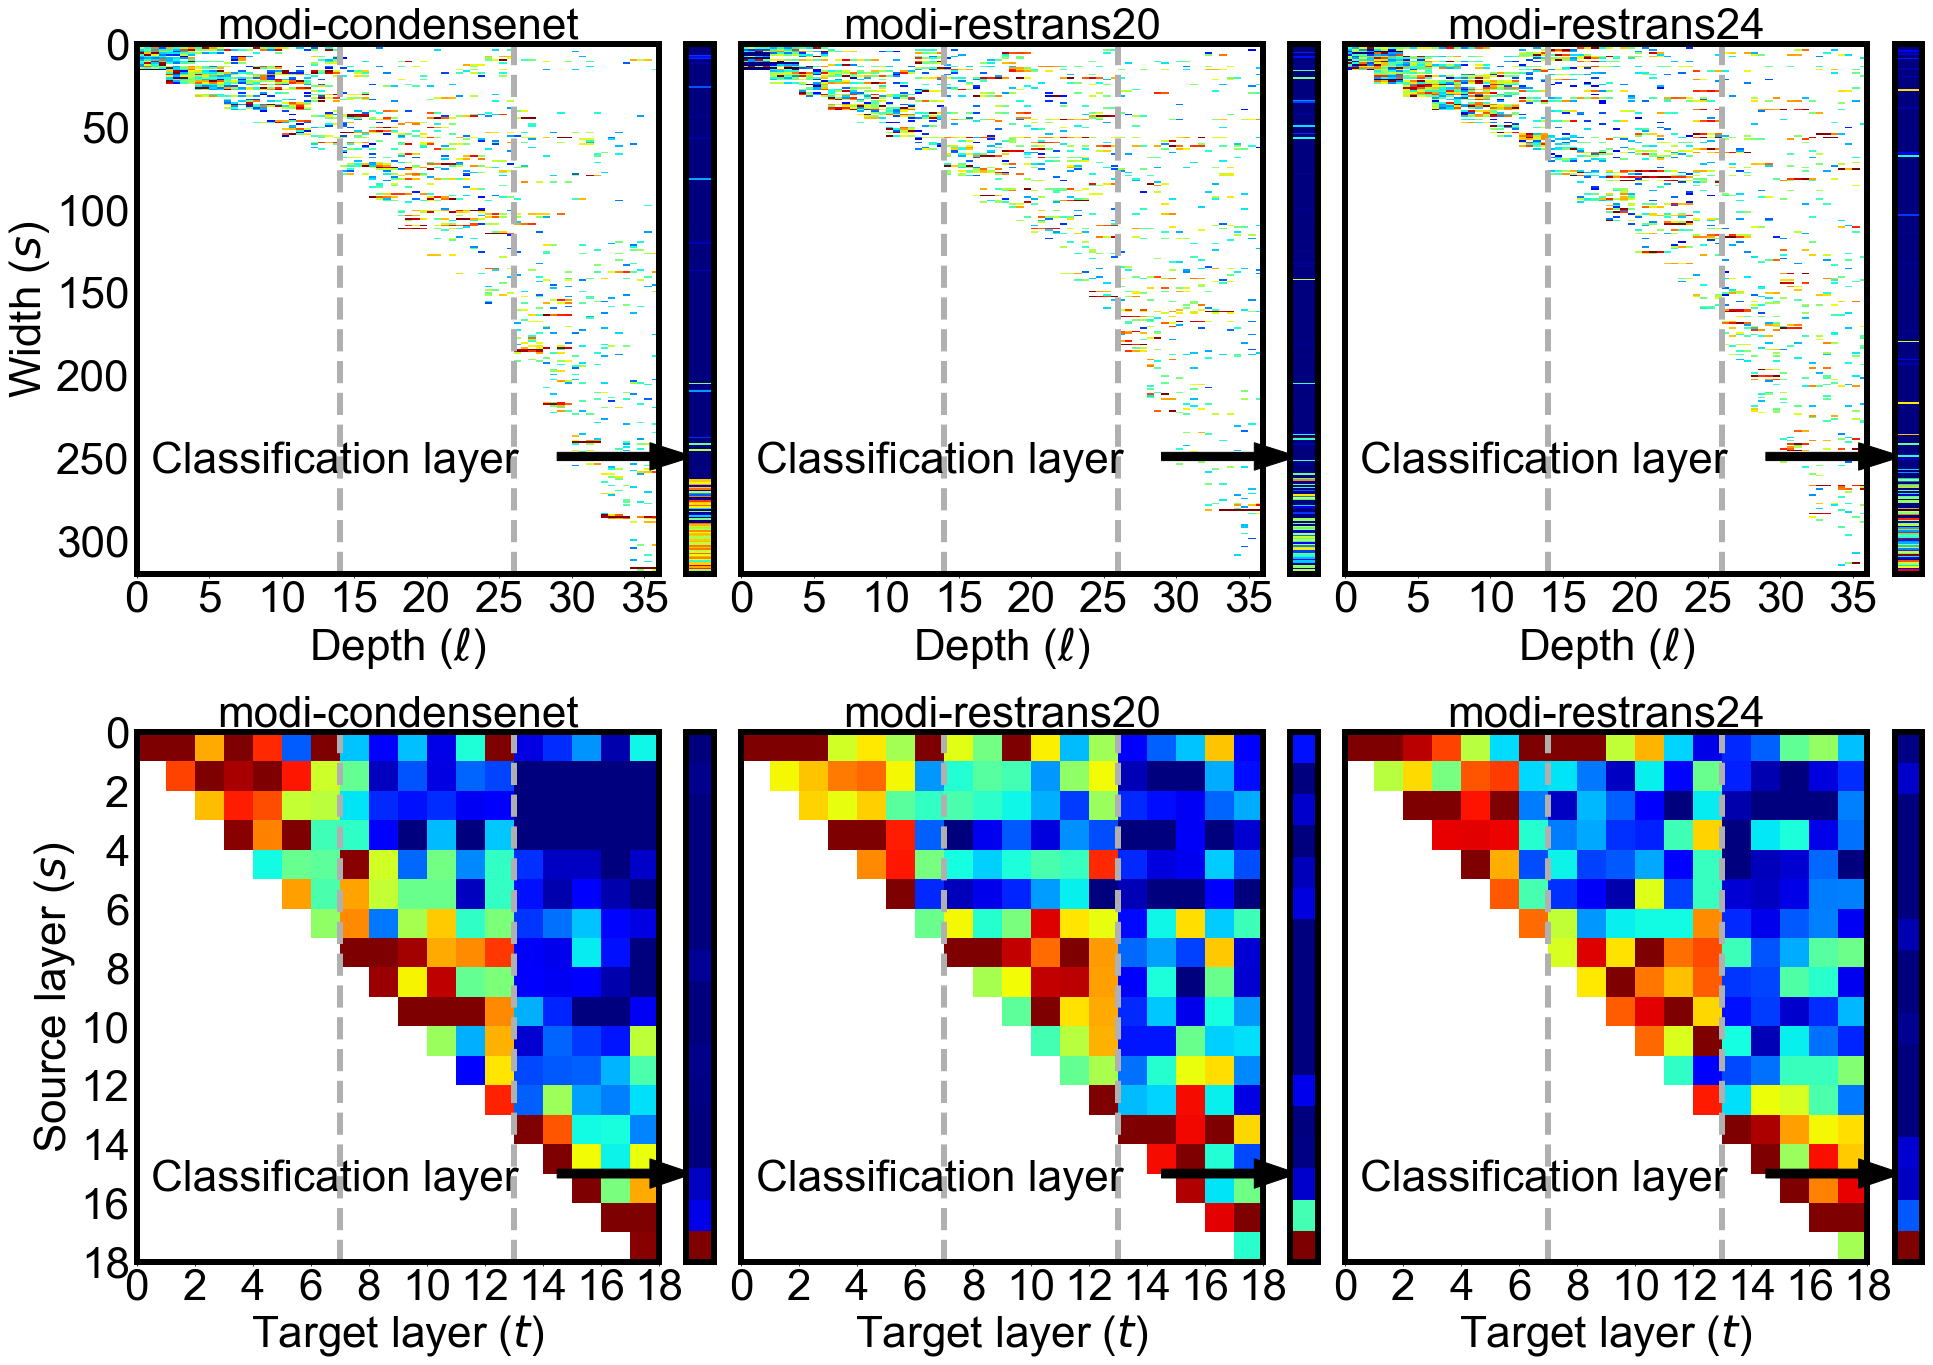

In [17]:
#LGC weight
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 33
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 3
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'modi\40_threshold20\save_models\model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold24\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
    if random != 0:
        all_masks = all_masks[1::2] 
        all_weights = all_weights[1::2] 
    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = conv*mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
    ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-1)//TOTAL)

    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))

    im = plt.imshow(whole_weights, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'modi-condensenet', size=FS*scale)
    elif random == 1:
        plt.title(r'modi-restrans20', size=FS*scale)
    else:
        plt.title(r'modi-restrans24', size=FS*scale)

    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
    arrow = ax.arrow(14.5*2, 15*h_s, 3.2*2, 0.0, fc="k", ec="k",
        head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
    arrow.set_clip_on(False)
    ax.text(0.5*2, 15.6*h_s, "Classification layer", 
            fontsize=FS*scale)  
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-1)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'modi-condensenet', size=FS*scale)
    elif random == 1:
        plt.title(r'modi-restrans20', size=FS*scale)
    else:
        plt.title(r'modi-restrans24', size=FS*scale)

    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
    arrow = ax.arrow(14.5, 15, 3.2, 0.0, fc="k", ec="k",
        head_width=1., head_length=1.5, width=.3,)
    arrow.set_clip_on(False)
    ax.text(0.5, 15.6, "Classification layer", 
            fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(classifier, interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet', extent=[0, 1,
                                                  whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGC_weight_modi-condensenet_modi-restrans20_modi-restrans24.pdf', bbox_inches='tight', format='pdf')

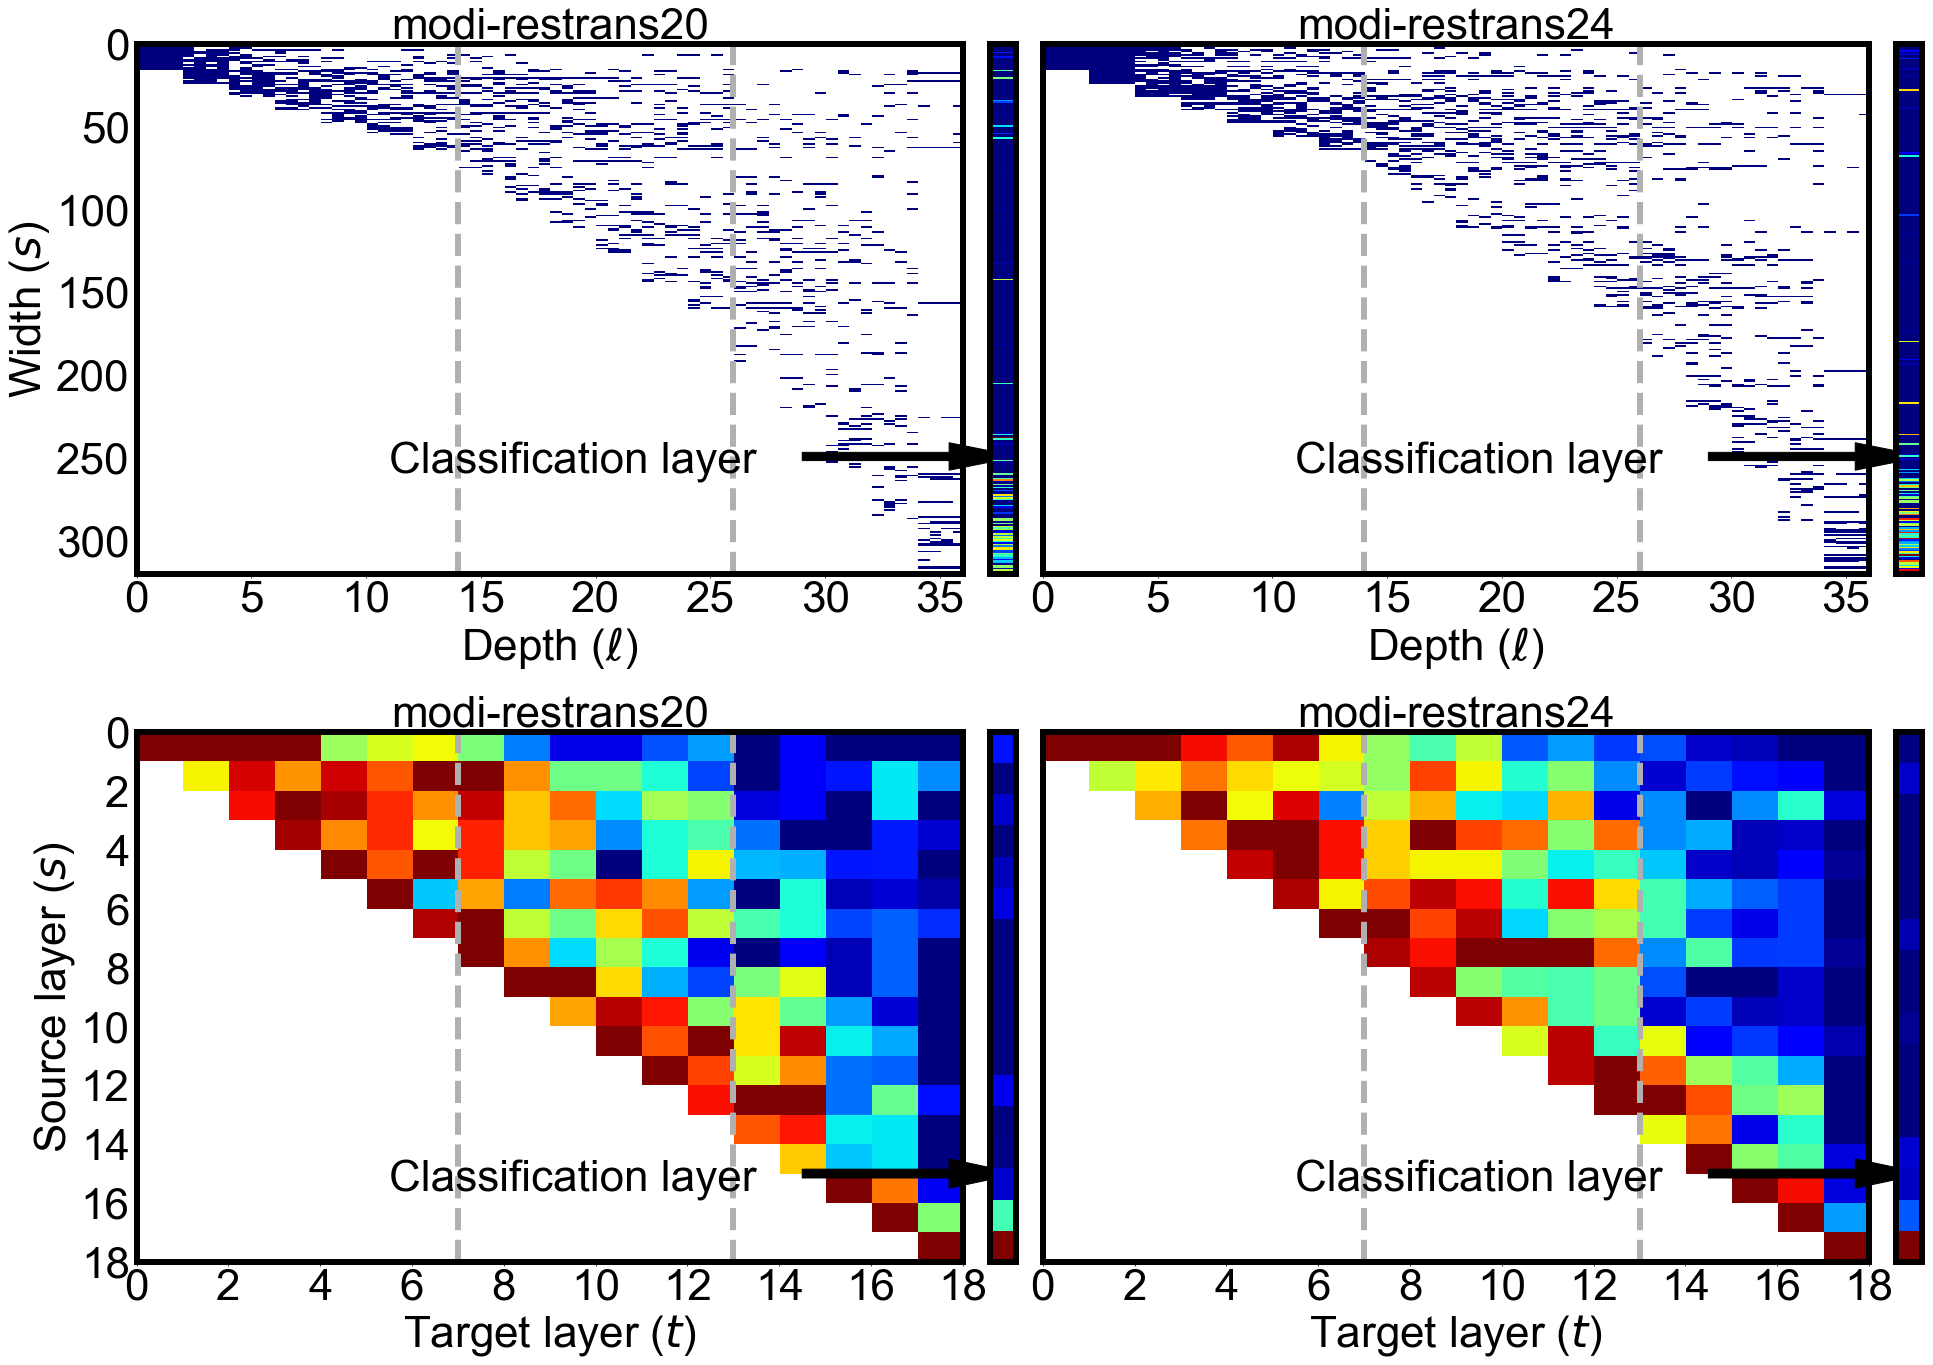

In [20]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'modi\40_threshold20\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'modi\40_threshold24\save_models\model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
    if random != 2:
        all_masks = all_masks[::2] 
        all_weights = all_weights[::2]
    for i in range(len(all_masks)):
        all_masks[i] = all_masks[i].T
        all_weights[i] = all_weights[i].T
    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
    ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-1)//TOTAL)

    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))
    whole_mask = np.ma.masked_where(whole_mask==0, np.log(whole_mask+1))
    im = plt.imshow(whole_mask, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'modi-restrans20', size=FS*scale)
    else:
        plt.title(r'modi-restrans24', size=FS*scale)

    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
    arrow = ax.arrow(14.5*2, 15*h_s, 3.2*2, 0.0, fc="k", ec="k",
        head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
    arrow.set_clip_on(False)
    ax.text(5.5*2, 15.6*h_s, "Classification layer", 
            fontsize=FS*scale)  
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-1)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'modi-restrans20', size=FS*scale)
    else:
        plt.title(r'modi-restrans24', size=FS*scale)

    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
    arrow = ax.arrow(14.5, 15, 3.2, 0.0, fc="k", ec="k",
        head_width=1., head_length=1.5, width=.3,)
    arrow.set_clip_on(False)
    ax.text(5.5, 15.6, "Classification layer", 
            fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(classifier, interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet', extent=[0, 1,
                                                  whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGCT_mask_modi-restrans20_modi-restrans24.pdf', bbox_inches='tight', format='pdf')

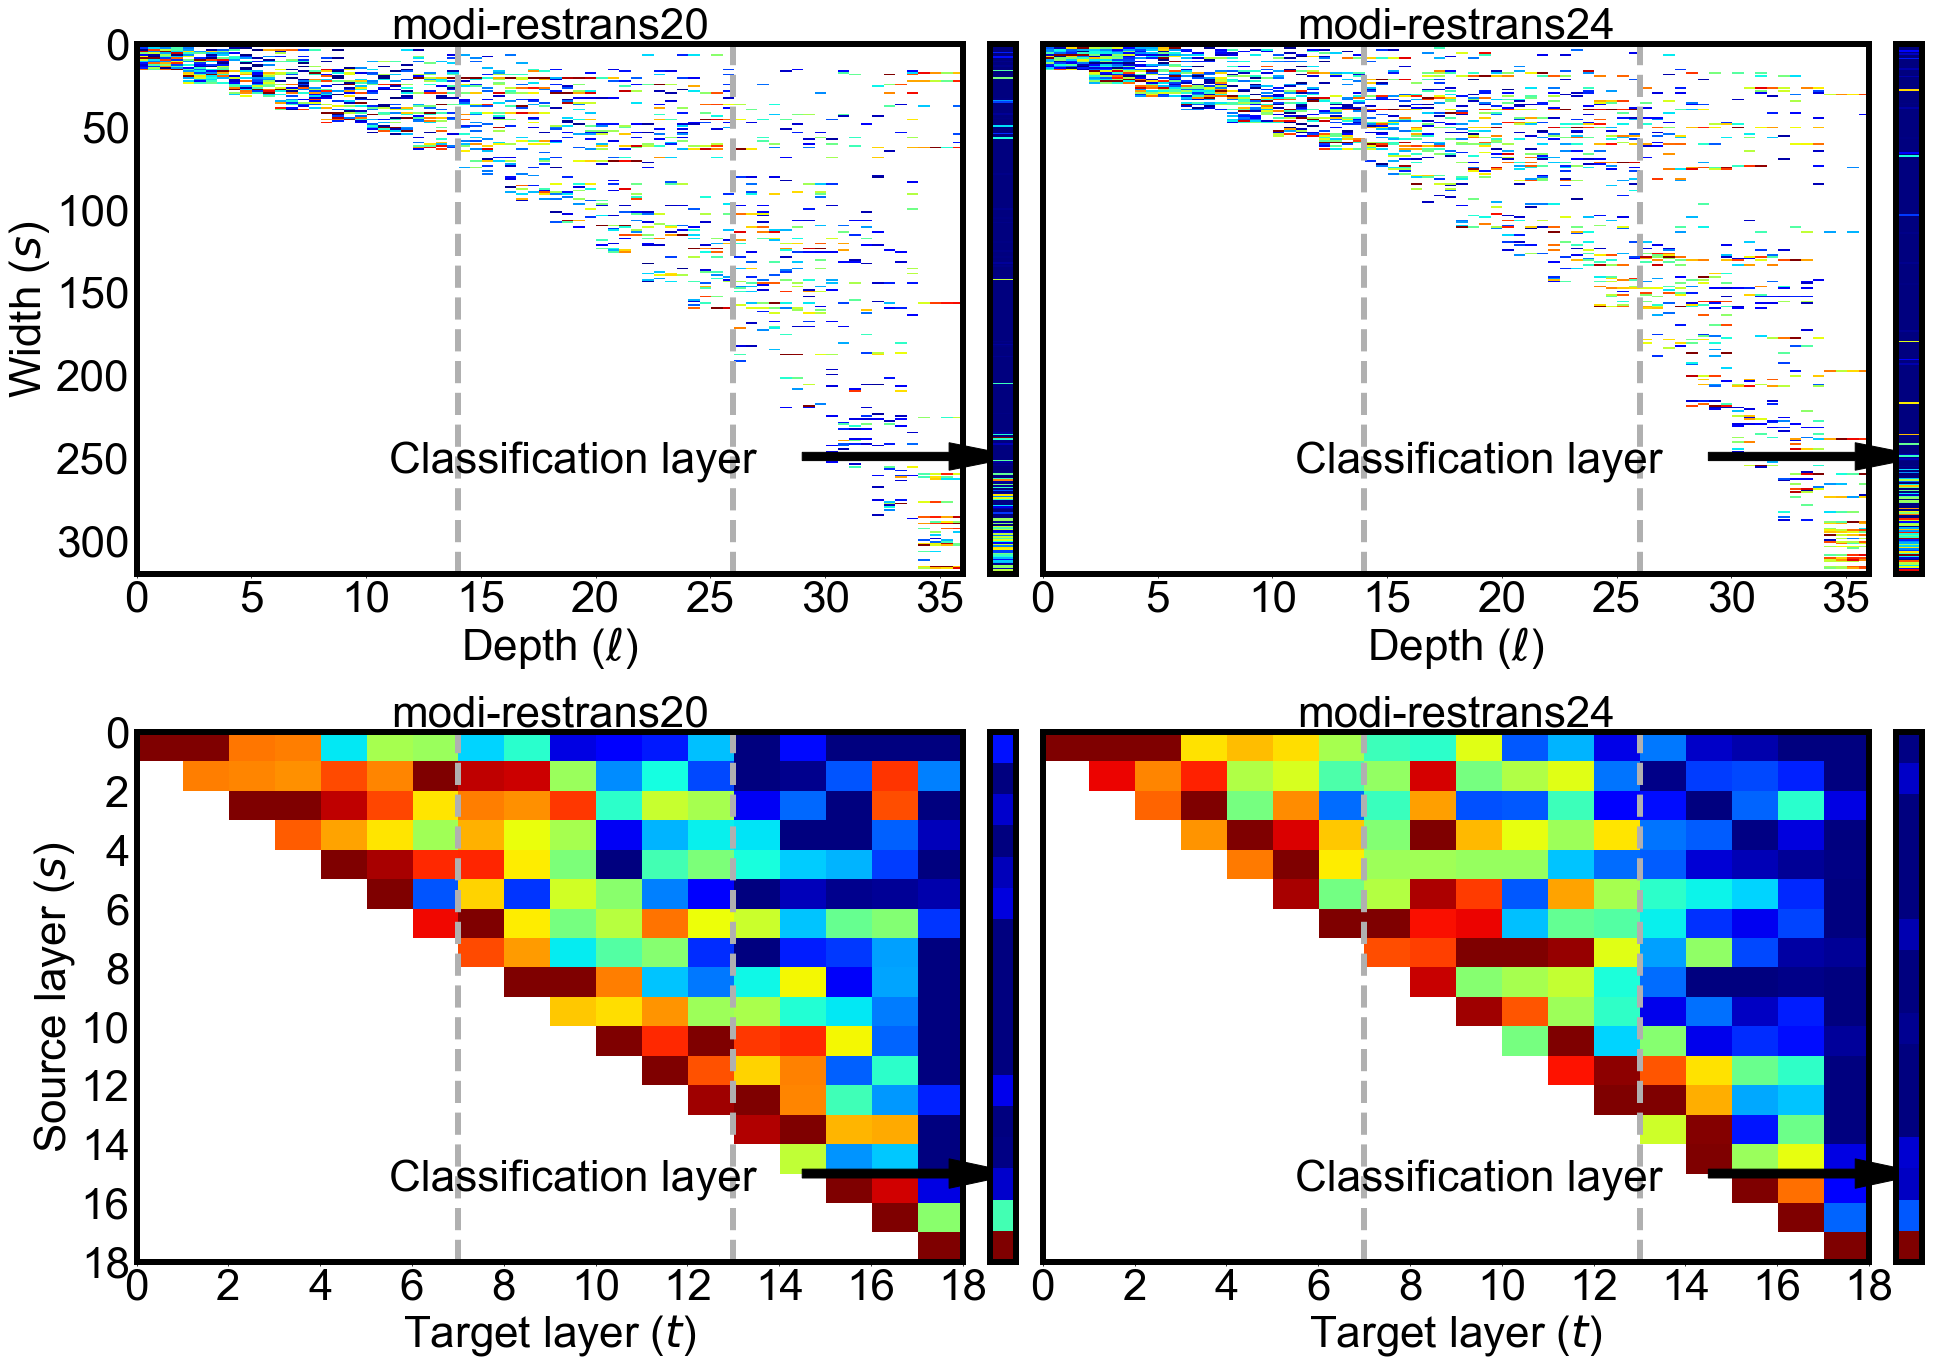

In [19]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'modi\40_threshold20\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'modi\40_threshold24\save_models\model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
    if random != 2:
        all_masks = all_masks[::2] 
        all_weights = all_weights[::2]
    for i in range(len(all_masks)):
        all_masks[i] = all_masks[i].T
        all_weights[i] = all_weights[i].T
    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = conv*mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
    ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-1)//TOTAL)

    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))

    im = plt.imshow(whole_weights, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'modi-restrans20', size=FS*scale)
    else:
        plt.title(r'modi-restrans24', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
    arrow = ax.arrow(14.5*2, 15*h_s, 3.2*2, 0.0, fc="k", ec="k",
        head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
    arrow.set_clip_on(False)
    ax.text(5.5*2, 15.6*h_s, "Classification layer", 
            fontsize=FS*scale)  
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-1)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'modi-restrans20', size=FS*scale)
    else:
        plt.title(r'modi-restrans24', size=FS*scale)
    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
    arrow = ax.arrow(14.5, 15, 3.2, 0.0, fc="k", ec="k",
        head_width=1., head_length=1.5, width=.3,)
    arrow.set_clip_on(False)
    ax.text(5.5, 15.6, "Classification layer", 
            fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(classifier, interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet', extent=[0, 1,
                                                  whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGCT_weight_modi-restrans20_modi-retrans24.pdf', bbox_inches='tight', format='pdf')

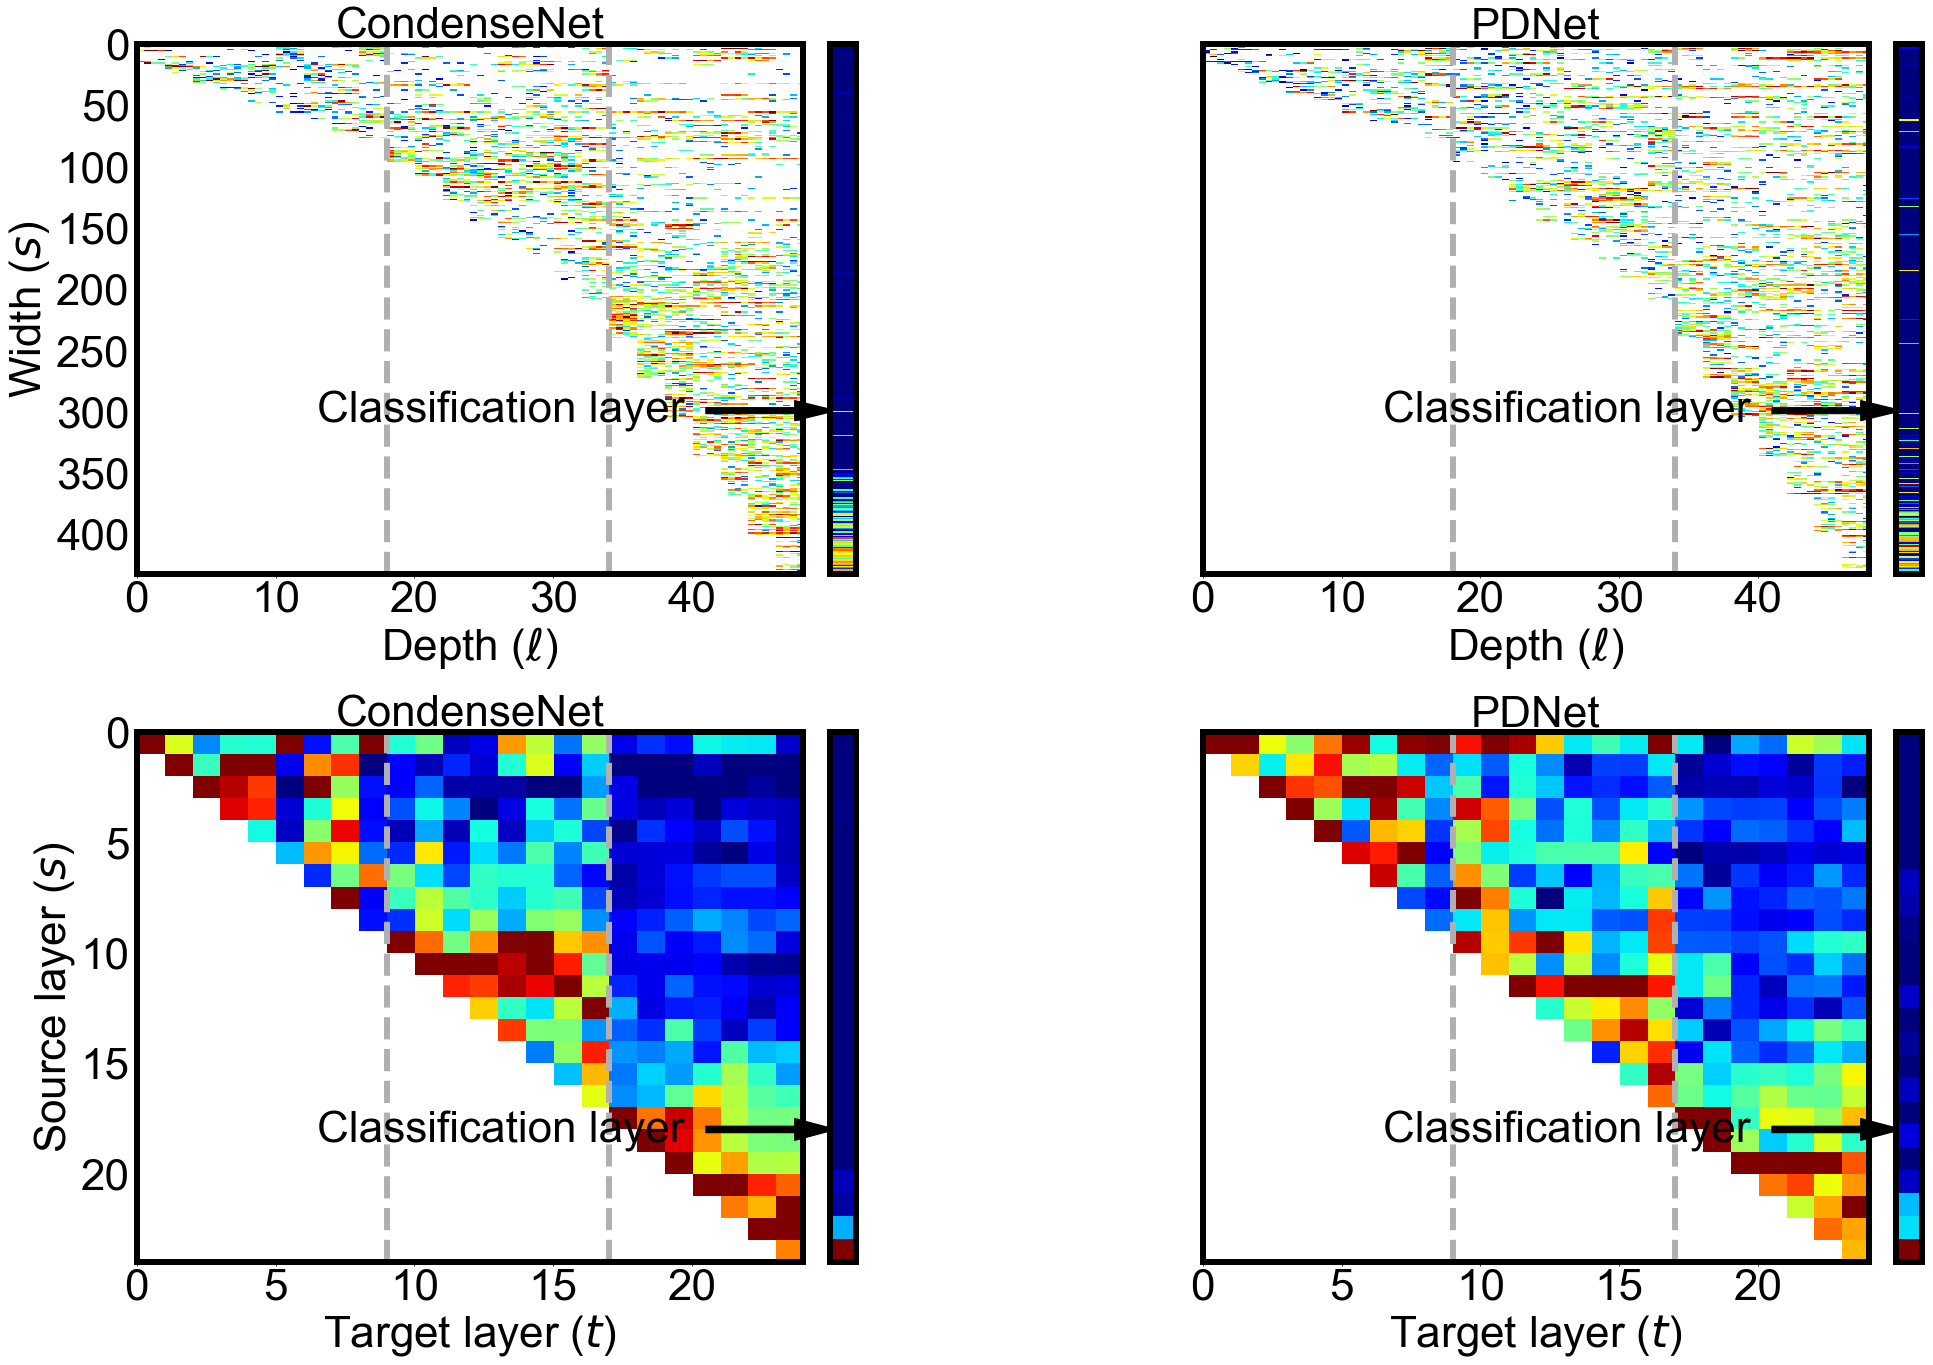

In [23]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condensenet52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
    if random != 0:
        all_masks = all_masks[1::2] 
        all_weights = all_weights[1::2]

    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = conv*mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)

    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))

    im = plt.imshow(whole_weights, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'CondenseNet', size=FS*scale)
    else:
        plt.title(r'PDNet', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
    arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
        head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
    arrow.set_clip_on(False)
    ax.text(6.5*2, 18.6*h_s, "Classification layer", 
            fontsize=FS*scale)  
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'CondenseNet', size=FS*scale)
    else:
        plt.title(r'PDNet', size=FS*scale)
    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
       
    ### Text
    arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
        head_width=1., head_length=1.5, width=.3,)
    arrow.set_clip_on(False)
    ax.text(6.5, 18.6, "Classification layer", 
            fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(classifier, interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet', extent=[0, 1,
                                                  whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGC_weight_CondenseNet_PDNet.pdf', bbox_inches='tight', format='pdf')

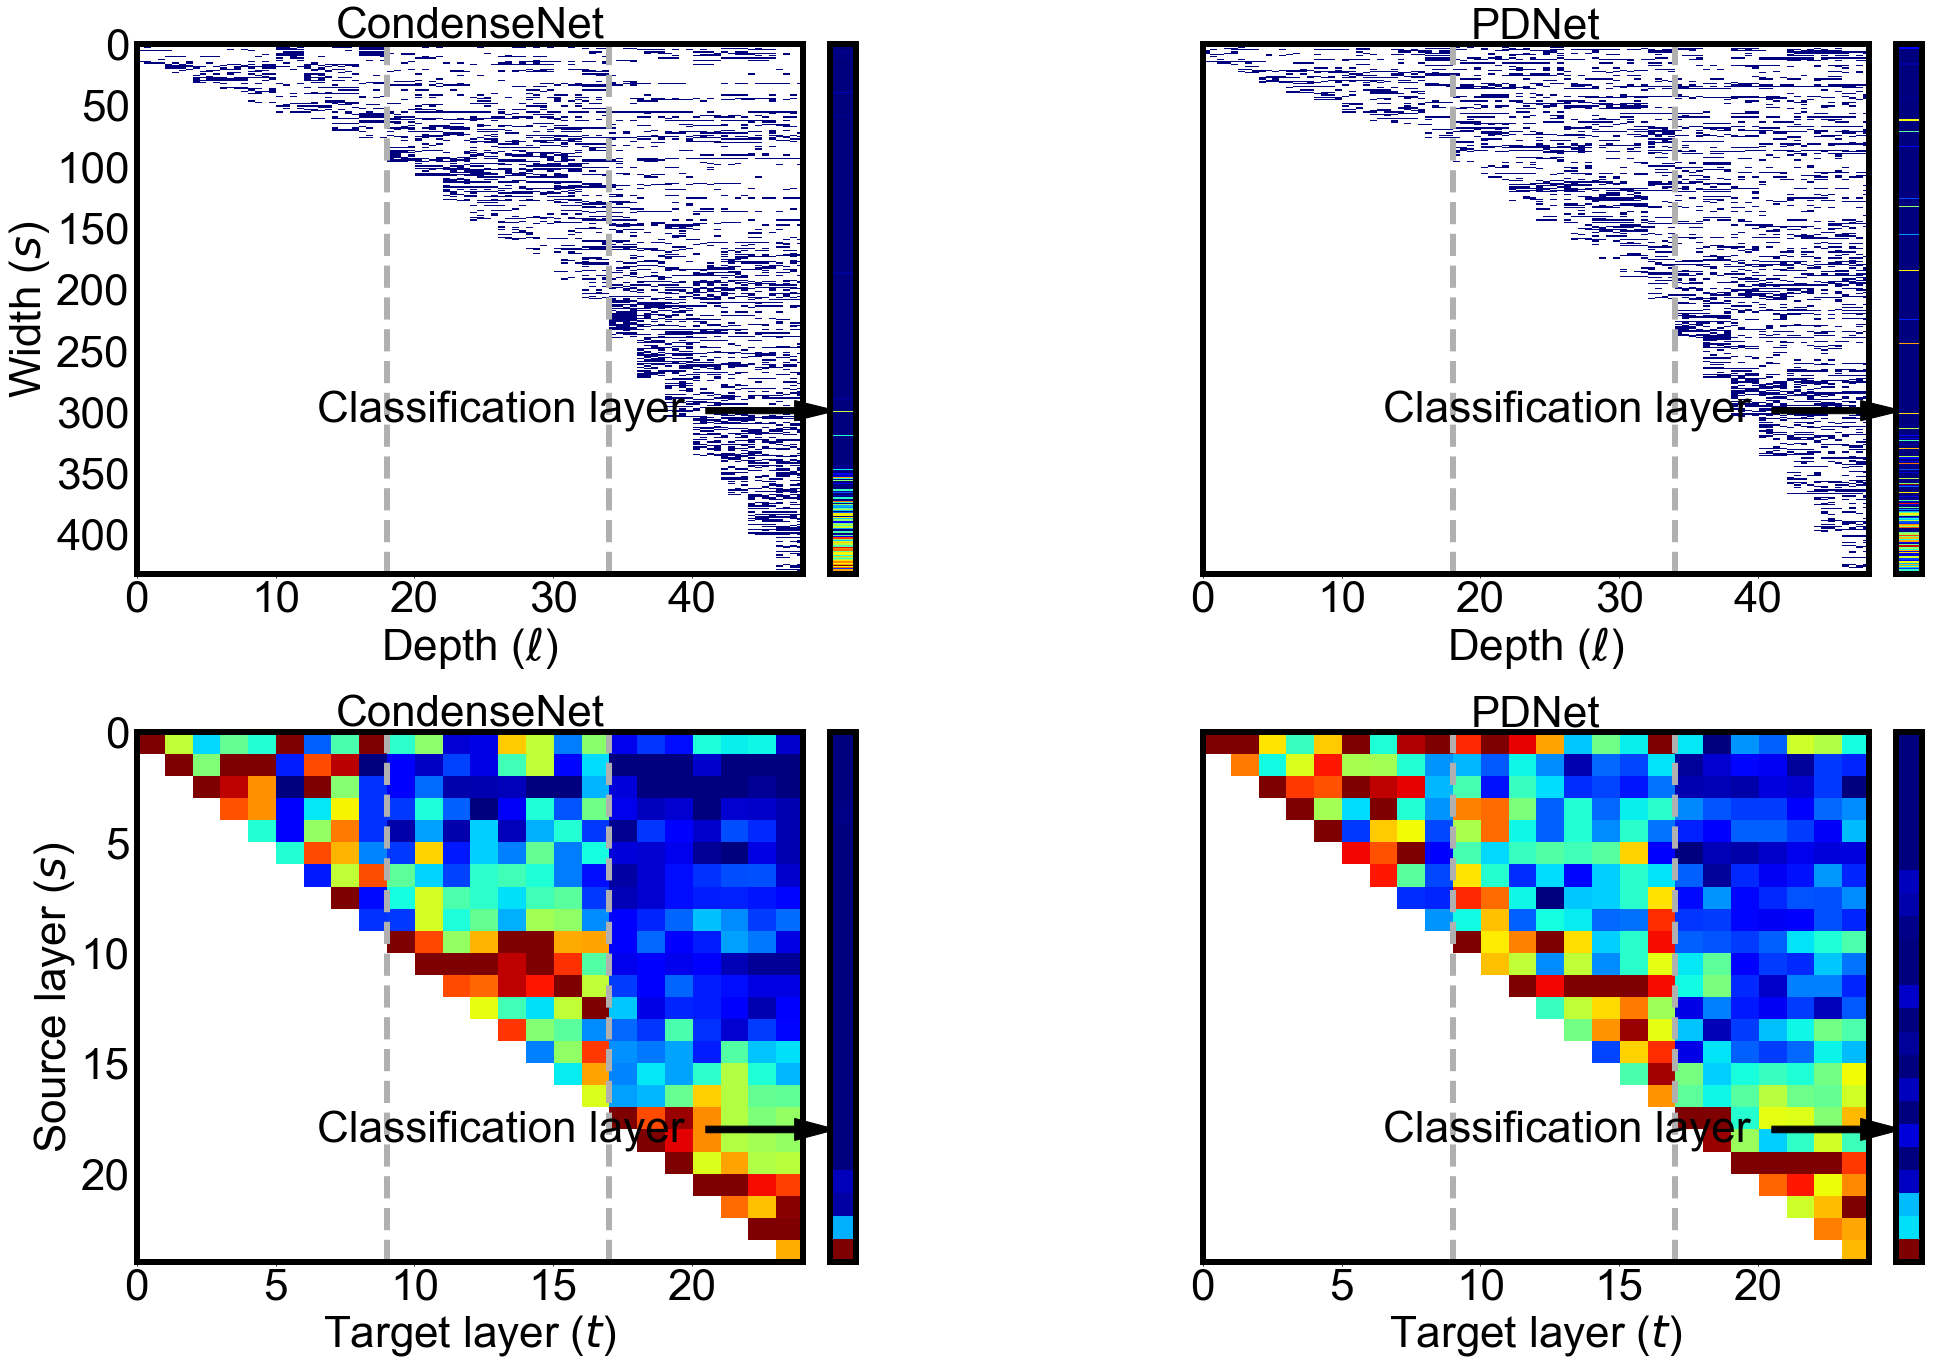

In [15]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condensenet52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
    if random != 0:
        all_masks = all_masks[1::2] 
        all_weights = all_weights[1::2]

    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)

    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))
    whole_mask = np.ma.masked_where(whole_mask==0, np.log(whole_mask+1))
    im = plt.imshow(whole_mask, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'CondenseNet', size=FS*scale)
    else:
        plt.title(r'PDNet', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
    arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
        head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
    arrow.set_clip_on(False)
    ax.text(6.5*2, 18.6*h_s, "Classification layer", 
            fontsize=FS*scale)  
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'CondenseNet', size=FS*scale)
    else:
        plt.title(r'PDNet', size=FS*scale)
    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
    arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
        head_width=1., head_length=1.5, width=.3,)
    arrow.set_clip_on(False)
    ax.text(6.5, 18.6, "Classification layer", 
            fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(classifier, interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet', extent=[0, 1,
                                                  whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGC_mask_CondenseNet_PDNet.pdf', bbox_inches='tight', format='pdf')

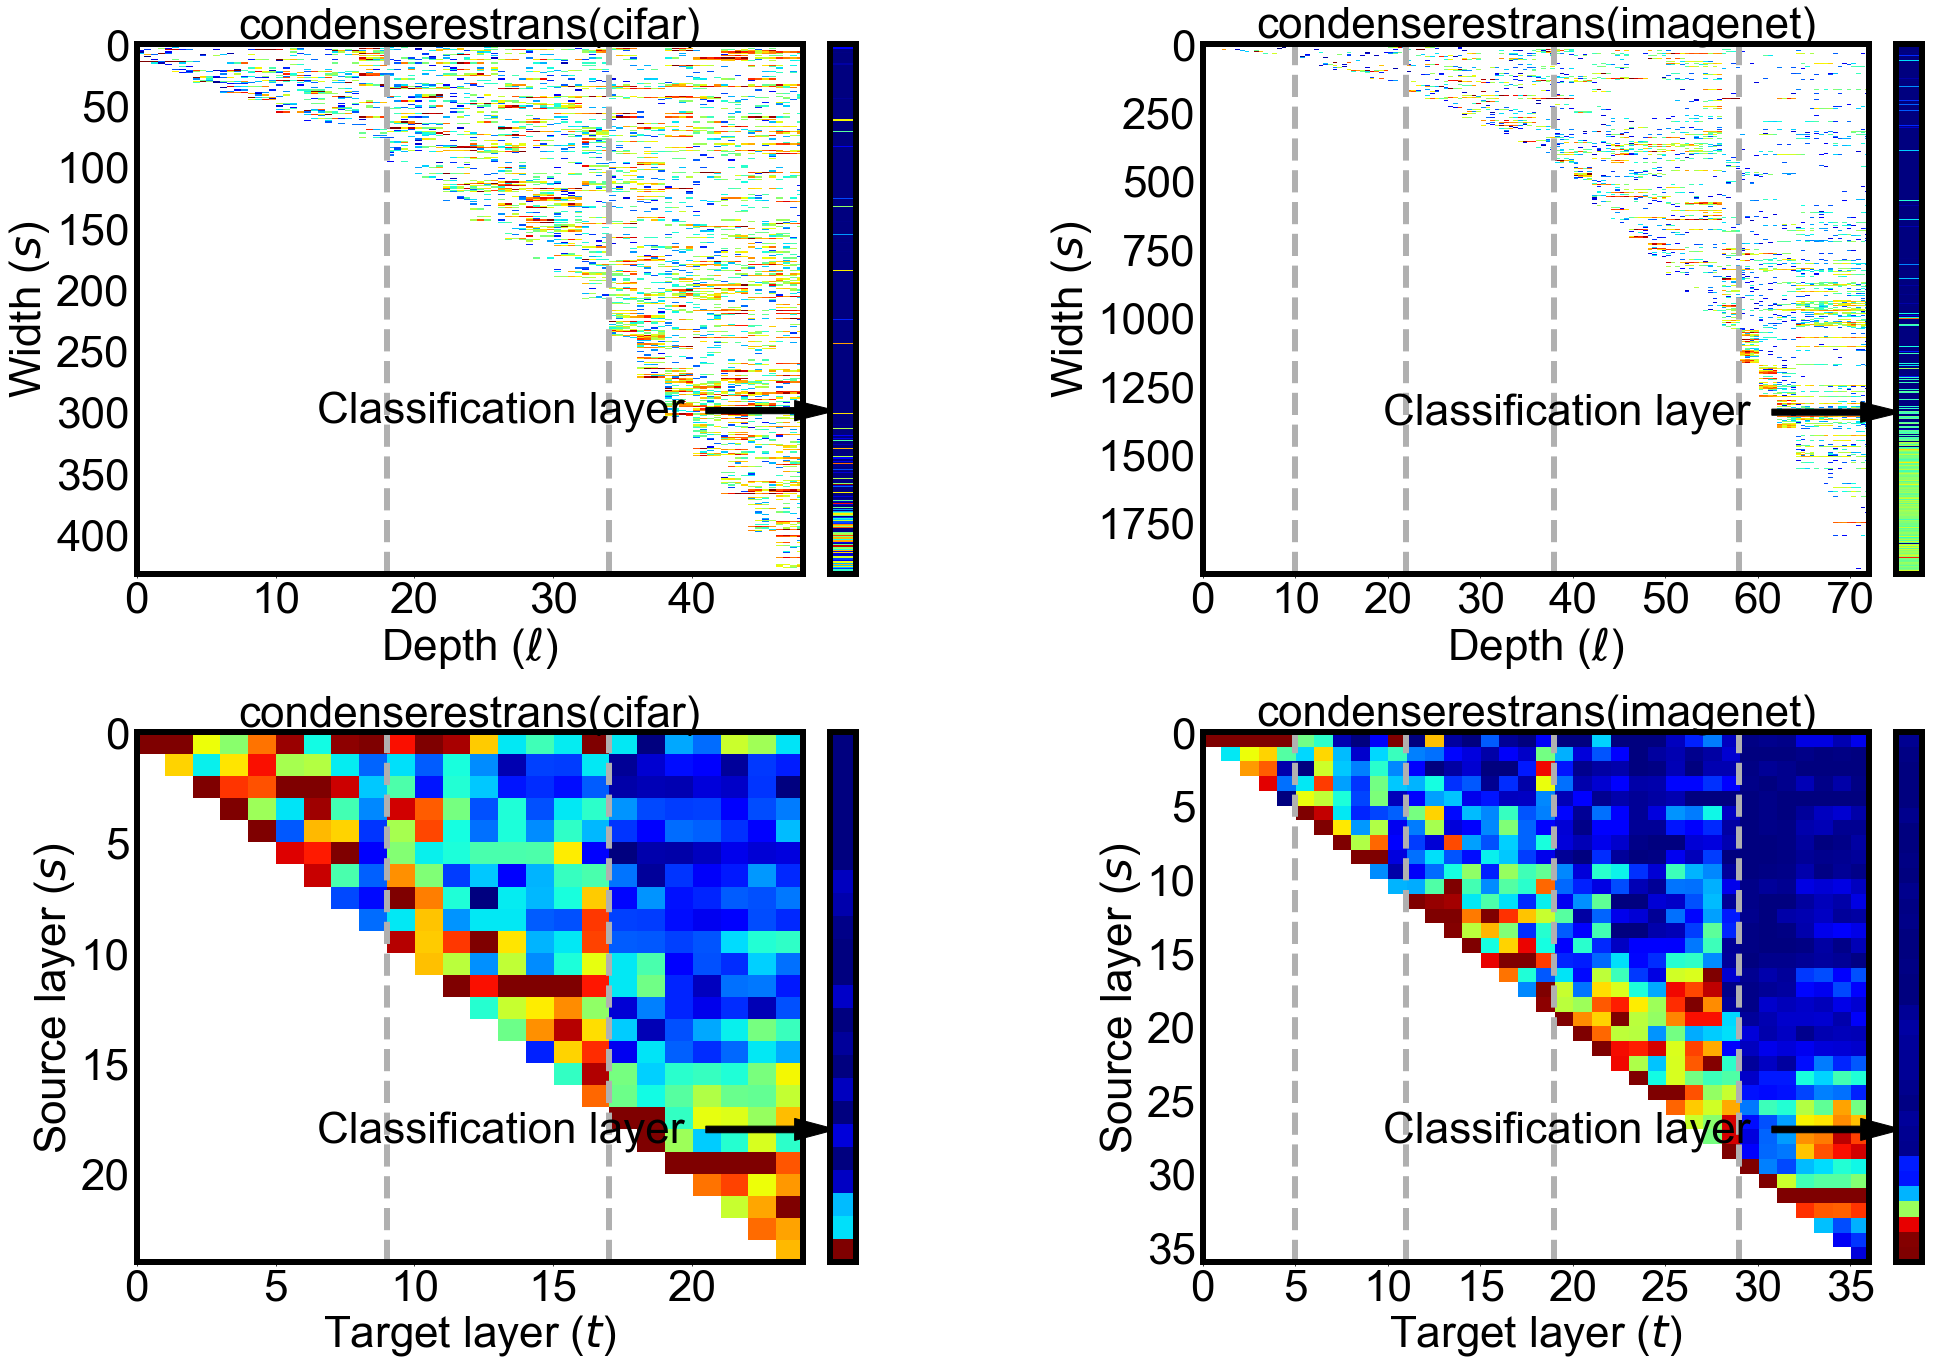

In [66]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
   
    all_masks = all_masks[1::2] 
    all_weights = all_weights[1::2]

    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = conv*mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))

    im = plt.imshow(whole_weights, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'condenserestrans(cifar)', size=FS*scale)
    else:
        plt.title(r'condenserestrans(imagenet)', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
    if random==0:
        arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
            head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
        arrow.set_clip_on(False)
        ax.text(6.5*2, 18.6*h_s, "Classification layer", 
                fontsize=FS*scale)  
    else:
        arrow = ax.arrow(20.5*2*1.5, 18*h_s*4.5, 3.2*2*1.5, 0.0, fc="k", ec="k",
            head_width=1.*h_s*4.5, head_length=1.5*2*1.5, width=.3*h_s*4.5,)
        arrow.set_clip_on(False)
        ax.text(6.5*2*1.5, 18.6*h_s*4.5, "Classification layer", 
                fontsize=FS*scale) 
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'condenserestrans(cifar)', size=FS*scale)
    else:
        plt.title(r'condenserestrans(imagenet)', size=FS*scale)
    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
    if random==0:
        arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
            head_width=1., head_length=1.5, width=.3,)
        arrow.set_clip_on(False)
        ax.text(6.5, 18.6, "Classification layer", 
                fontsize=FS*scale)
    else:
        arrow = ax.arrow(20.5*1.5, 18*1.5, 3.2*1.5, 0.0, fc="k", ec="k",
            head_width=1*1.5, head_length=1.5*1.5, width=.3*1.5,)
        arrow.set_clip_on(False)
        ax.text(6.5*1.5, 18.6*1.5, "Classification layer", 
                fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(classifier, interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet', extent=[0, 1,
                                                  whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGC_weight_condenserestrans(cifar)_condenserestrans(imagenet).pdf', bbox_inches='tight', format='pdf')

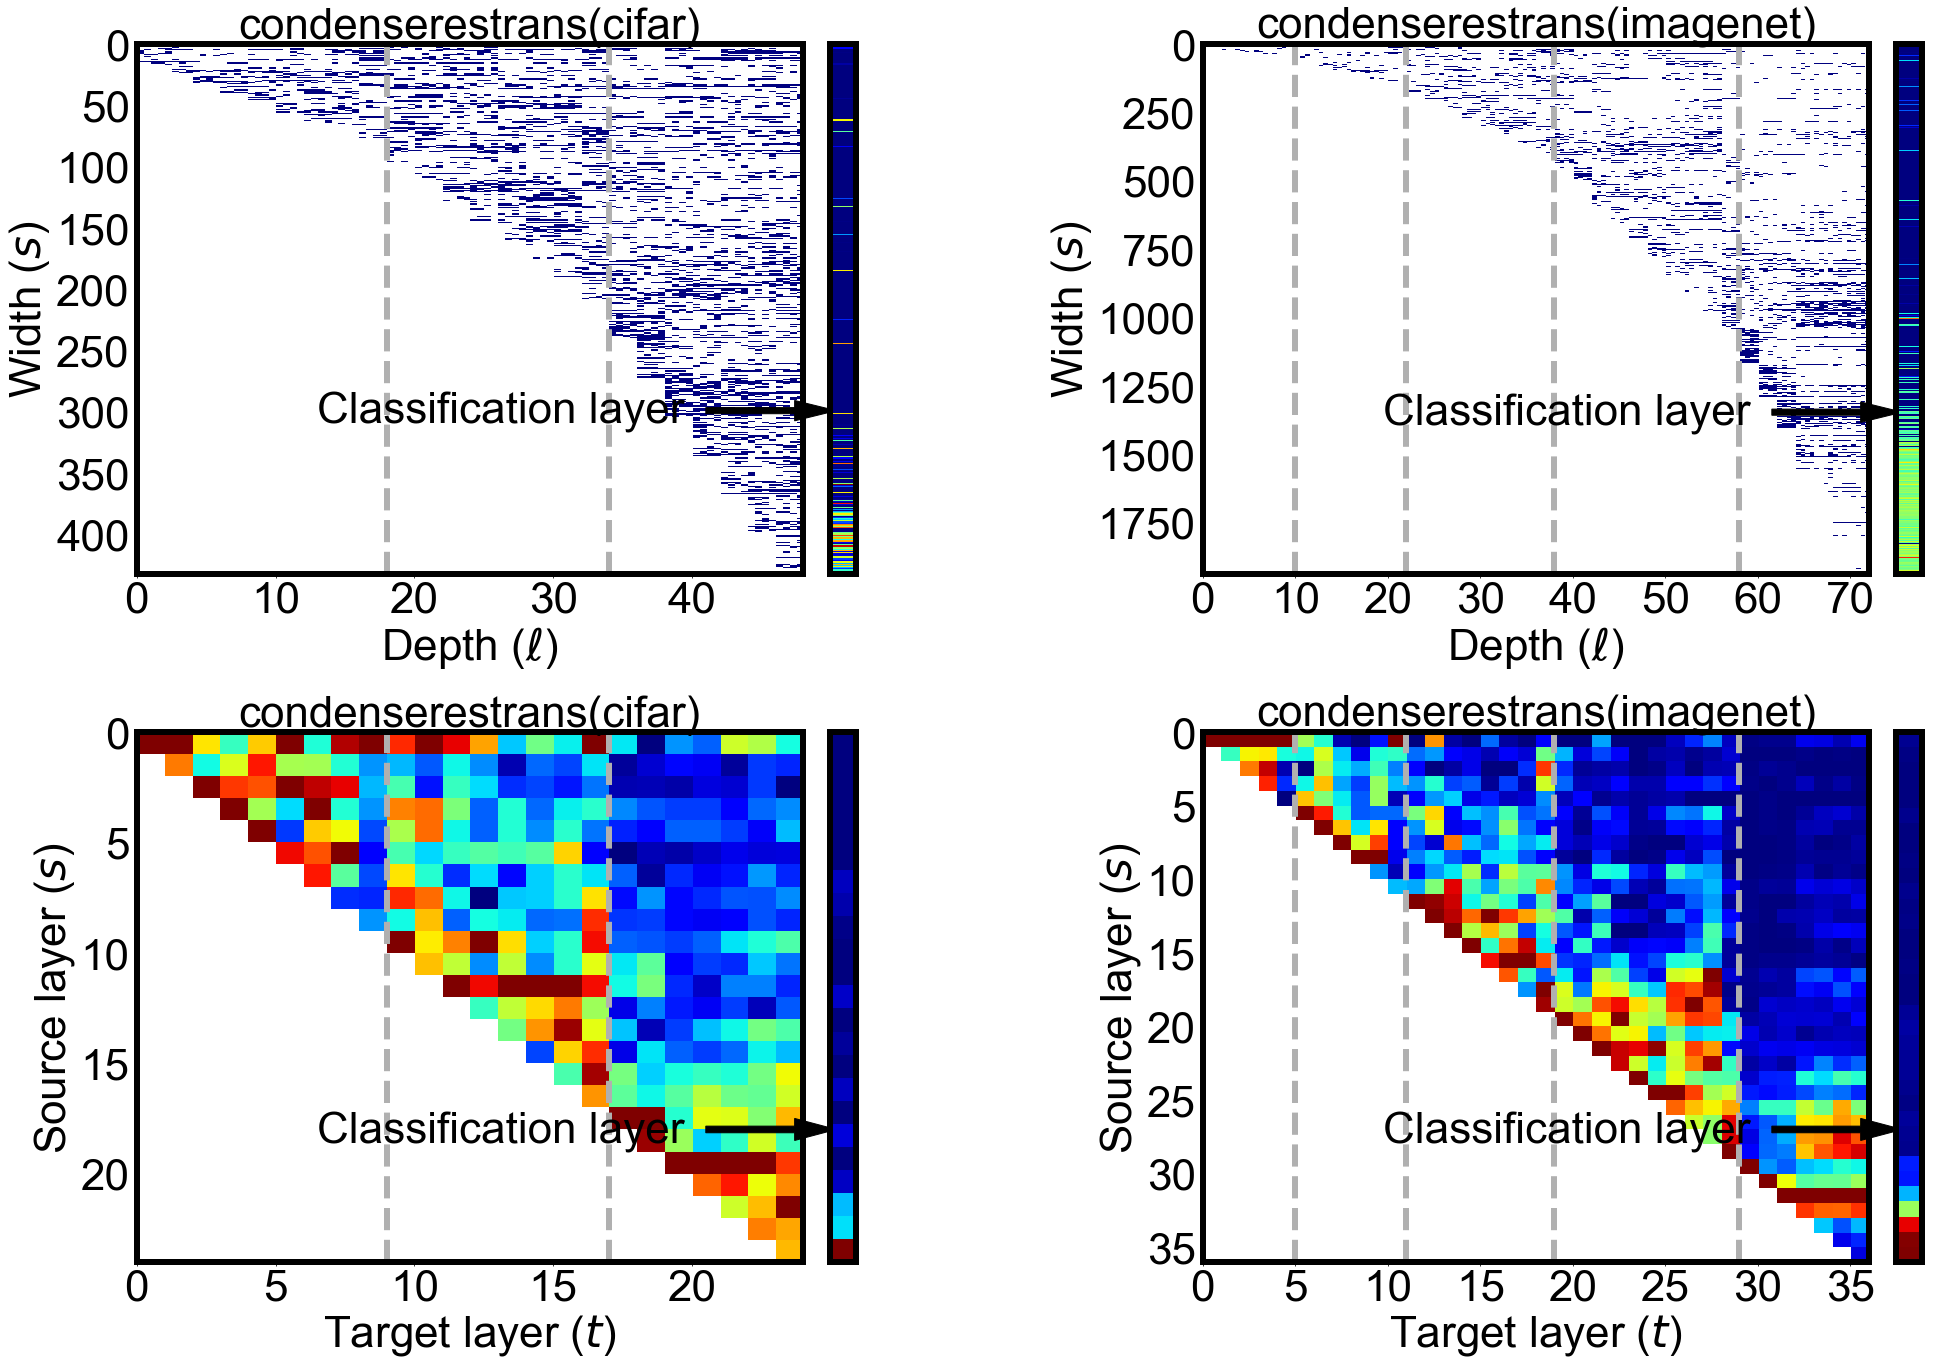

In [67]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
   
    all_masks = all_masks[1::2] 
    all_weights = all_weights[1::2]

    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))
    whole_mask = np.ma.masked_where(whole_mask==0, np.log(whole_mask+1))
    im = plt.imshow(whole_mask, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'condenserestrans(cifar)', size=FS*scale)
    else:
        plt.title(r'condenserestrans(imagenet)', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
    if random==0:
        arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
            head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
        arrow.set_clip_on(False)
        ax.text(6.5*2, 18.6*h_s, "Classification layer", 
                fontsize=FS*scale)  
    else:
        arrow = ax.arrow(20.5*2*1.5, 18*h_s*4.5, 3.2*2*1.5, 0.0, fc="k", ec="k",
            head_width=1.*h_s*4.5, head_length=1.5*2*1.5, width=.3*h_s*4.5,)
        arrow.set_clip_on(False)
        ax.text(6.5*2*1.5, 18.6*h_s*4.5, "Classification layer", 
                fontsize=FS*scale) 
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'condenserestrans(cifar)', size=FS*scale)
    else:
        plt.title(r'condenserestrans(imagenet)', size=FS*scale)
    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
    if random==0:
        arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
            head_width=1., head_length=1.5, width=.3,)
        arrow.set_clip_on(False)
        ax.text(6.5, 18.6, "Classification layer", 
                fontsize=FS*scale)
    else:
        arrow = ax.arrow(20.5*1.5, 18*1.5, 3.2*1.5, 0.0, fc="k", ec="k",
            head_width=1*1.5, head_length=1.5*1.5, width=.3*1.5,)
        arrow.set_clip_on(False)
        ax.text(6.5*1.5, 18.6*1.5, "Classification layer", 
                fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(classifier, interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet', extent=[0, 1,
                                                  whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGC_mask_condenserestrans(cifar)_condenserestrans(imagenet).pdf', bbox_inches='tight', format='pdf')

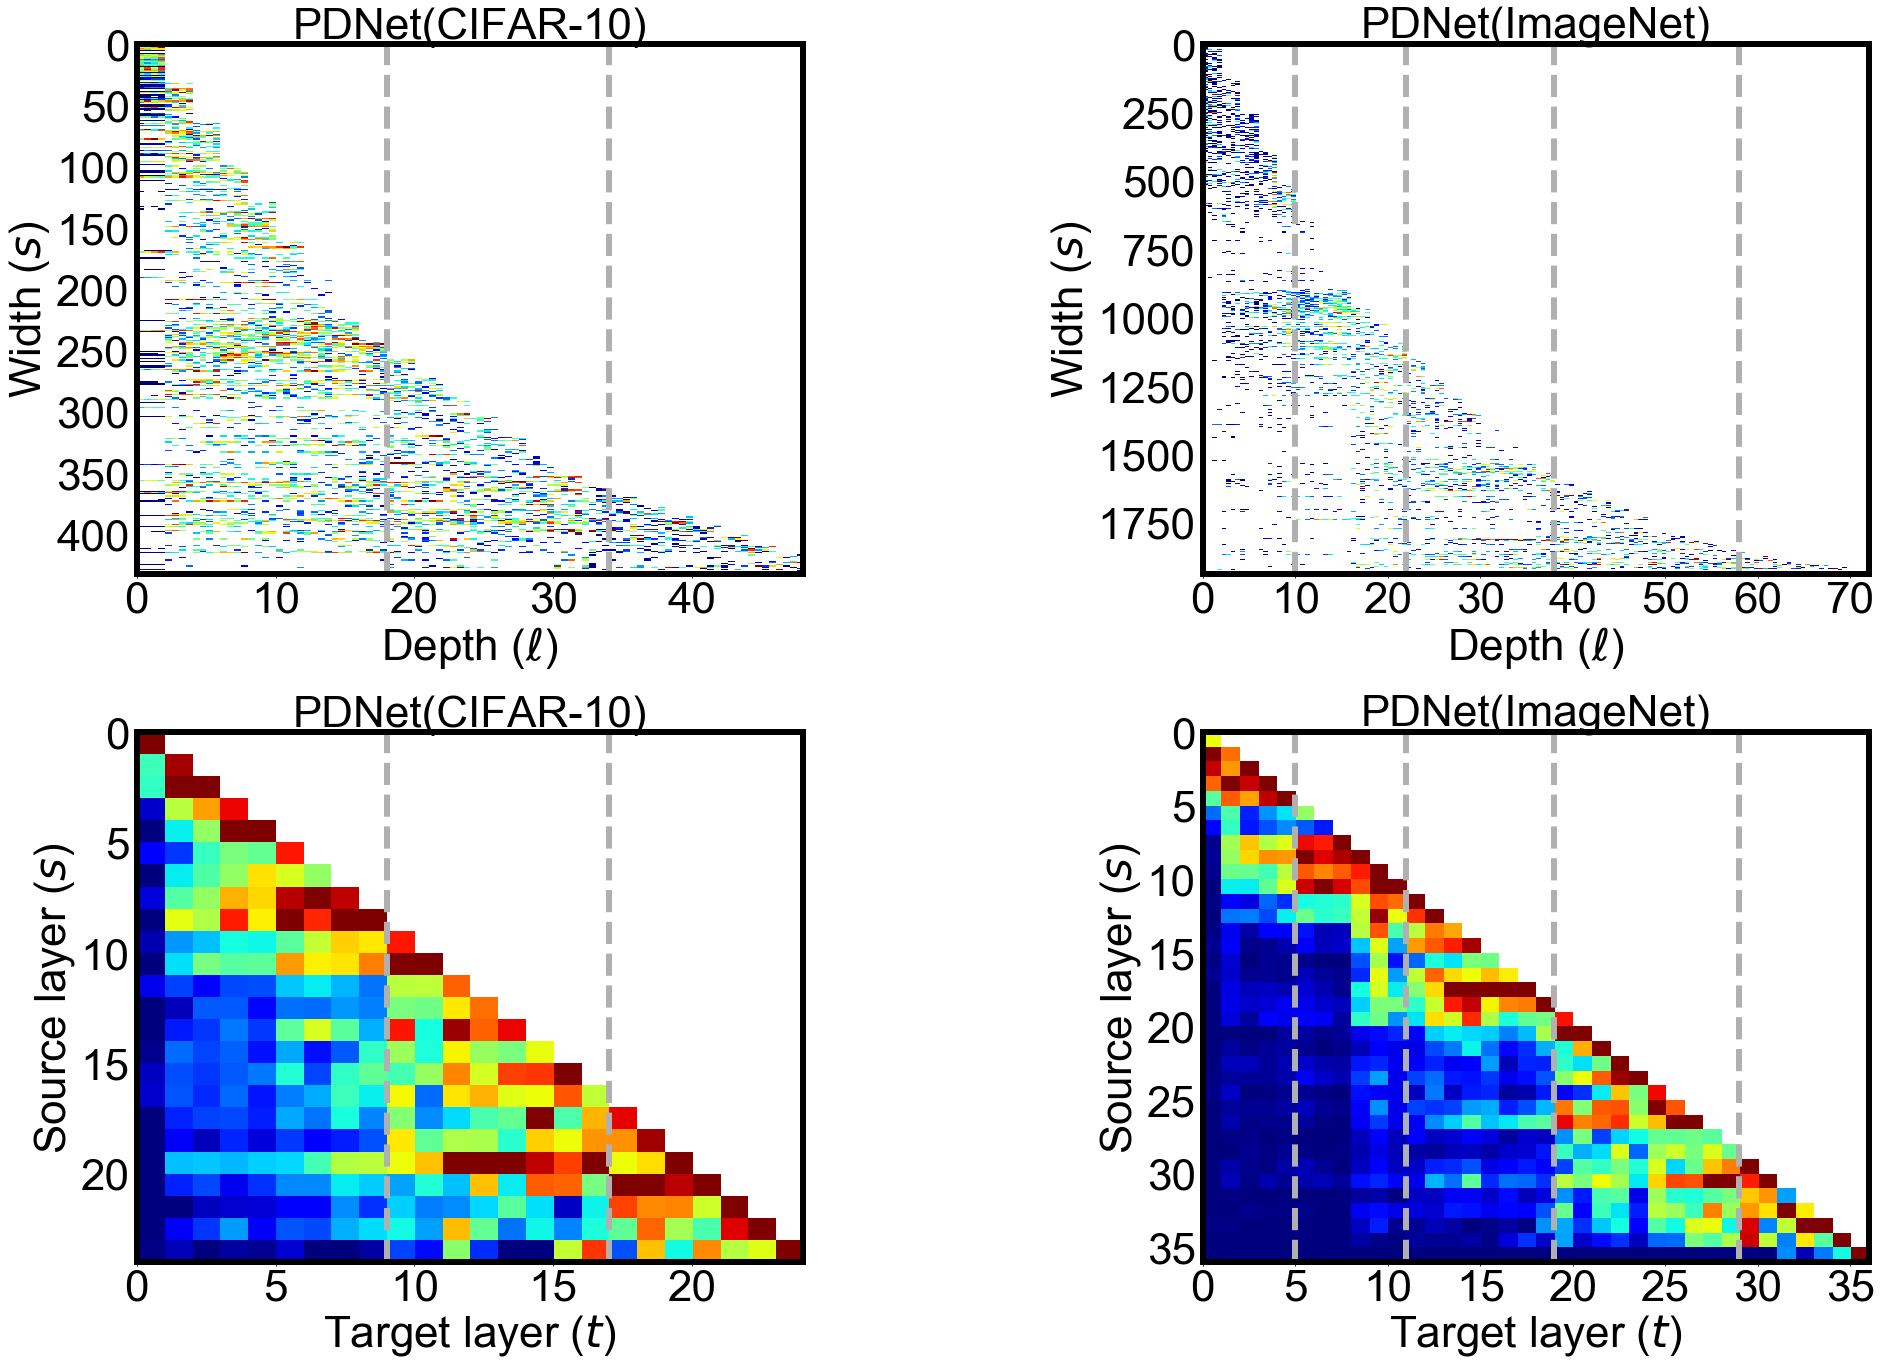

In [14]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
   
    all_masks = all_masks[::2] 
    all_weights = all_weights[::2]
    for i in range(len(all_masks)):
        all_masks[i] = all_masks[i].T
        all_weights[i] = all_weights[i].T
        
    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

    
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
#         print(conv.shape)
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = conv*mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
#     print(whole_weights)
#     print("qwer")
    whole_weights = whole_weights[:,range(whole_weights.shape[1]-1,-1,-1)]
    whole_weights = whole_weights[range(whole_weights.shape[0]-1,-1,-1),:]
    whole_mask = whole_mask[:,range(whole_mask.shape[1]-1,-1,-1)]
    whole_mask = whole_mask[range(whole_mask.shape[0]-1,-1,-1),:]
#     print(whole_weights)
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))

    im = plt.imshow(whole_weights, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
#     if random==0:
#         arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
#             head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2, 18.6*h_s, "Classification layer", 
#                 fontsize=FS*scale)  
#     else:
#         arrow = ax.arrow(20.5*2*1.5, 18*h_s*4.5, 3.2*2*1.5, 0.0, fc="k", ec="k",
#             head_width=1.*h_s*4.5, head_length=1.5*2*1.5, width=.3*h_s*4.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2*1.5, 18.6*h_s*4.5, "Classification layer", 
#                 fontsize=FS*scale) 
    ################
    #
    ################
#     whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    whole_l2l = whole_l2l[:,range(whole_l2l.shape[1]-1,-1,-1)]
    whole_l2l = whole_l2l[range(whole_l2l.shape[0]-1,-1,-1),:]
    whole_l2l = np.ma.masked_where(np.tril(whole_l2l+1) == 0, np.log(whole_l2l+1))
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     if random==0:
#         arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
#             head_width=1., head_length=1.5, width=.3,)
#         arrow.set_clip_on(False)
#         ax.text(6.5, 18.6, "Classification layer", 
#                 fontsize=FS*scale)
#     else:
#         arrow = ax.arrow(20.5*1.5, 18*1.5, 3.2*1.5, 0.0, fc="k", ec="k",
#             head_width=1*1.5, head_length=1.5*1.5, width=.3*1.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*1.5, 18.6*1.5, "Classification layer", 
#                 fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
#     plt.imshow(classifier, interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet', extent=[0, 1,
#                                                   whole_weights.shape[0], 0])
#     ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
#     if random==0:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
#     else:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
#     plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGCT_weight_PDNet(CIFAR-10)_PDNet(ImageNet).pdf', bbox_inches='tight', format='pdf')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


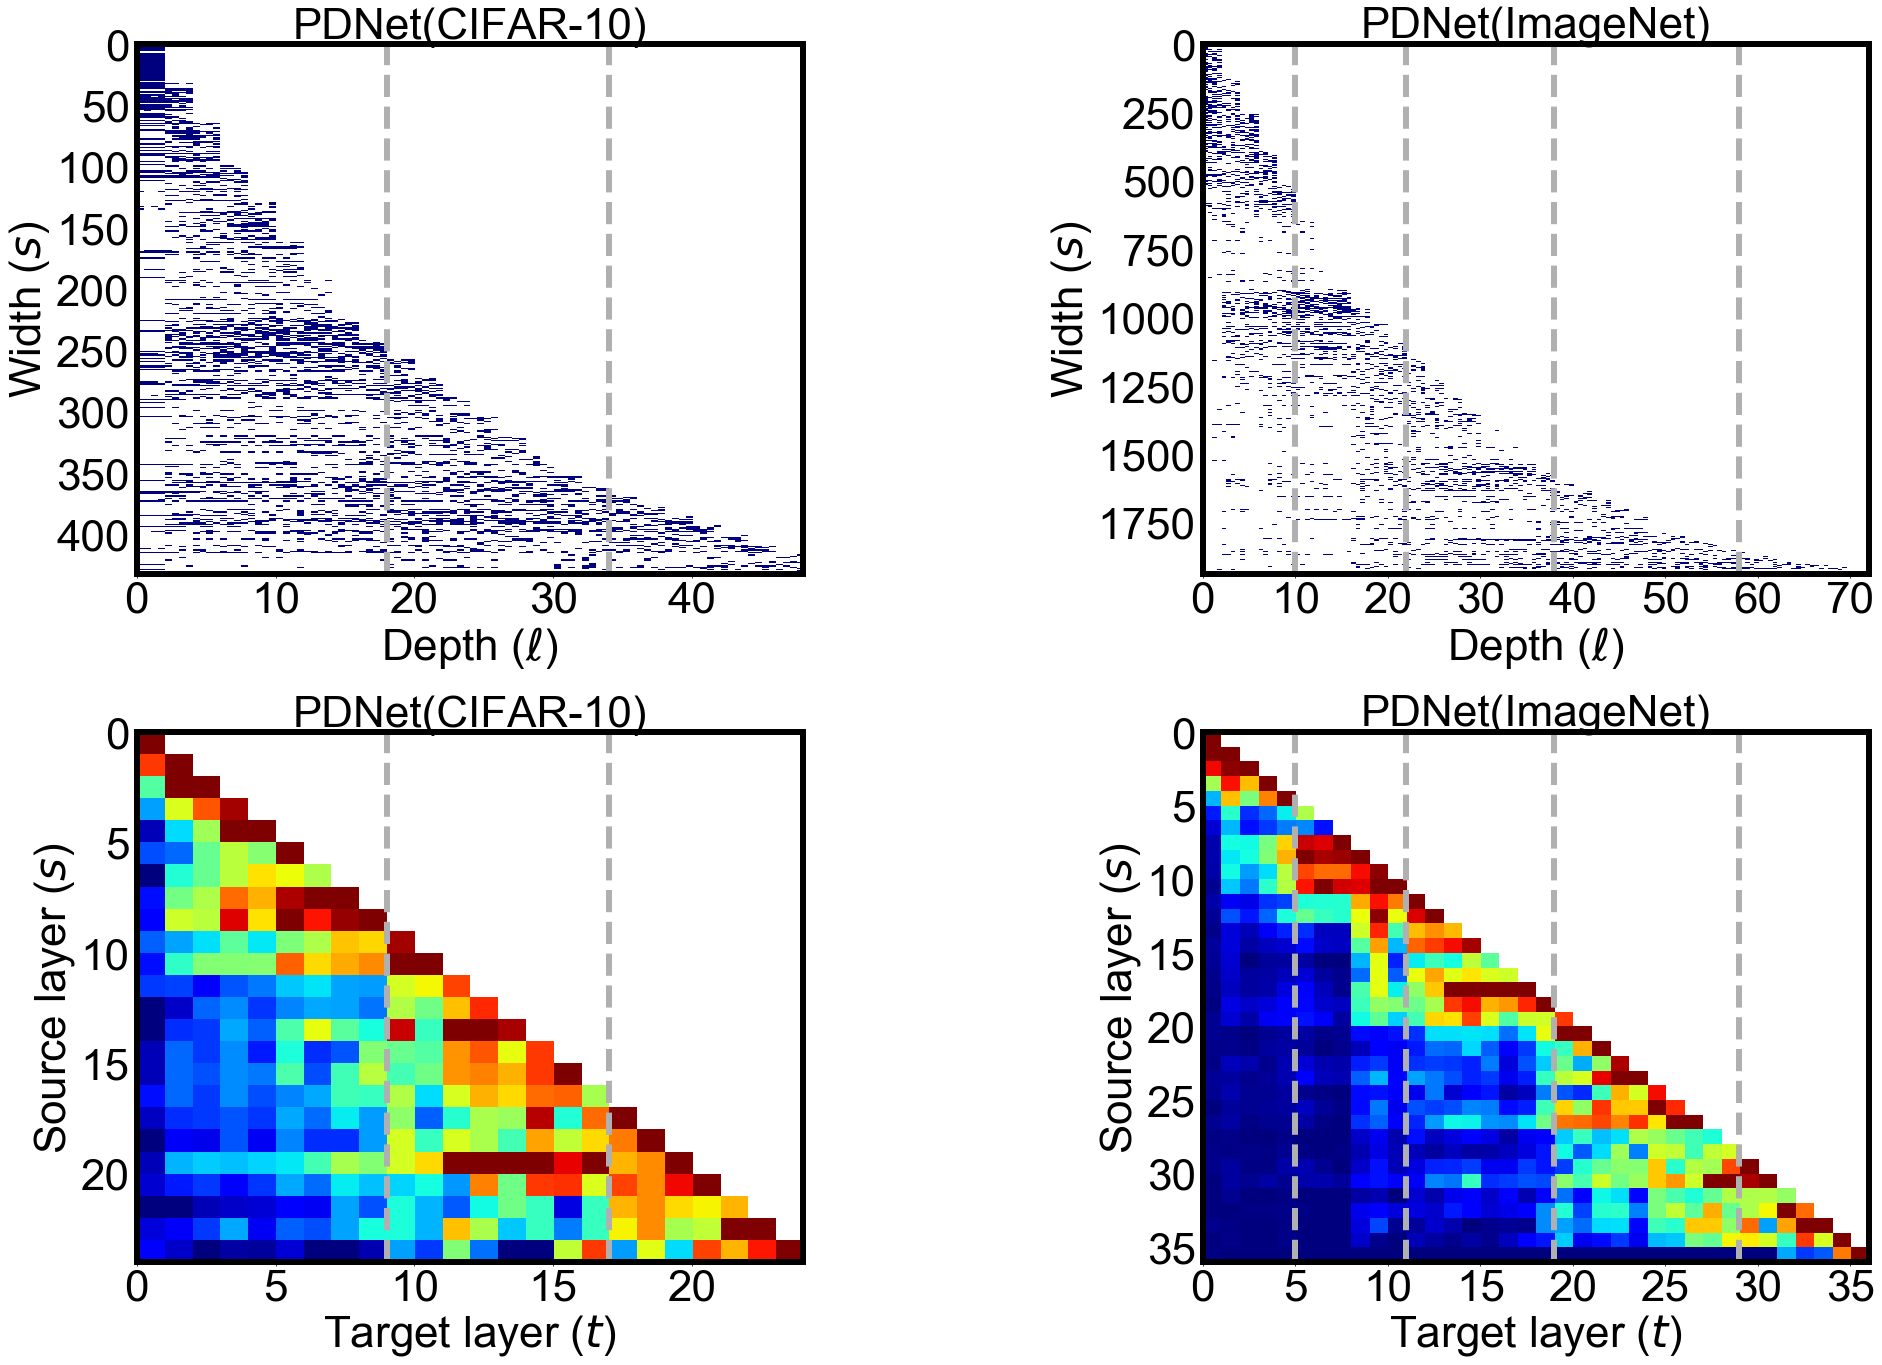

In [13]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
    print(type(all_masks[1]))
   
    all_masks = all_masks[::2] 
    all_weights = all_weights[::2]
    for i in range(len(all_masks)):
        all_masks[i] = all_masks[i].T
        all_weights[i] = all_weights[i].T
    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
    whole_weights = whole_weights[:,range(whole_weights.shape[1]-1,-1,-1)]
    whole_weights = whole_weights[range(whole_weights.shape[0]-1,-1,-1),:]
    whole_mask = whole_mask[:,range(whole_mask.shape[1]-1,-1,-1)]
    whole_mask = whole_mask[range(whole_mask.shape[0]-1,-1,-1),:]
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))
    whole_mask = np.ma.masked_where(whole_mask==0, np.log(whole_mask+1))
    im = plt.imshow(whole_mask, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
#     if random==0:
#         arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
#             head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2, 18.6*h_s, "Classification layer", 
#                 fontsize=FS*scale)  
#     else:
#         arrow = ax.arrow(20.5*2*1.5, 18*h_s*4.5, 3.2*2*1.5, 0.0, fc="k", ec="k",
#             head_width=1.*h_s*4.5, head_length=1.5*2*1.5, width=.3*h_s*4.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2*1.5, 18.6*h_s*4.5, "Classification layer", 
#                 fontsize=FS*scale) 
    ################
    #
    ################
#     whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    whole_l2l = whole_l2l[:,range(whole_l2l.shape[1]-1,-1,-1)]
    whole_l2l = whole_l2l[range(whole_l2l.shape[0]-1,-1,-1),:]
    whole_l2l = np.ma.masked_where(np.tril(whole_l2l+1) == 0, np.log(whole_l2l+1))
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     if random==0:
#         arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
#             head_width=1., head_length=1.5, width=.3,)
#         arrow.set_clip_on(False)
#         ax.text(6.5, 18.6, "Classification layer", 
#                 fontsize=FS*scale)
#     else:
#         arrow = ax.arrow(20.5*1.5, 18*1.5, 3.2*1.5, 0.0, fc="k", ec="k",
#             head_width=1*1.5, head_length=1.5*1.5, width=.3*1.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*1.5, 18.6*1.5, "Classification layer", 
#                 fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
#     plt.imshow(classifier, interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet', extent=[0, 1,
#                                                   whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
#     if random==0:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
#     else:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
#     plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGCT_mask_PDNet(CIFAR-10)_PDNet(ImageNet).pdf', bbox_inches='tight', format='pdf')

In [ ]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condensenet52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
    if random != 0:
        all_masks = all_masks[1::2] 
        all_weights = all_weights[1::2]

    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = conv*mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
    ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-1)//TOTAL)

    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))

    im = plt.imshow(whole_weights, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'condensenet52', size=FS*scale)
    else:
        plt.title(r'condenserestrans52', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
    arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
        head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
    arrow.set_clip_on(False)
    ax.text(6.5*2, 18.6*h_s, "Classification layer", 
            fontsize=FS*scale)  
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
    ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-1)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
    if random != 0:
        ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'condensenet52', size=FS*scale)
    else:
        plt.title(r'condenserestrans52', size=FS*scale)
    ### Labels
    plt.xlabel(r'Target layer ($t$)', size=FS*scale)
    if random == 0:
        plt.ylabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
    arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
        head_width=1., head_length=1.5, width=.3,)
    arrow.set_clip_on(False)
    ax.text(6.5, 18.6, "Classification layer", 
            fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(classifier, interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet', extent=[0, 1,
                                                  whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
    plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
               aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('average\LGC_weight_condensenet52_condenserestrans52.pdf', bbox_inches='tight', format='pdf')

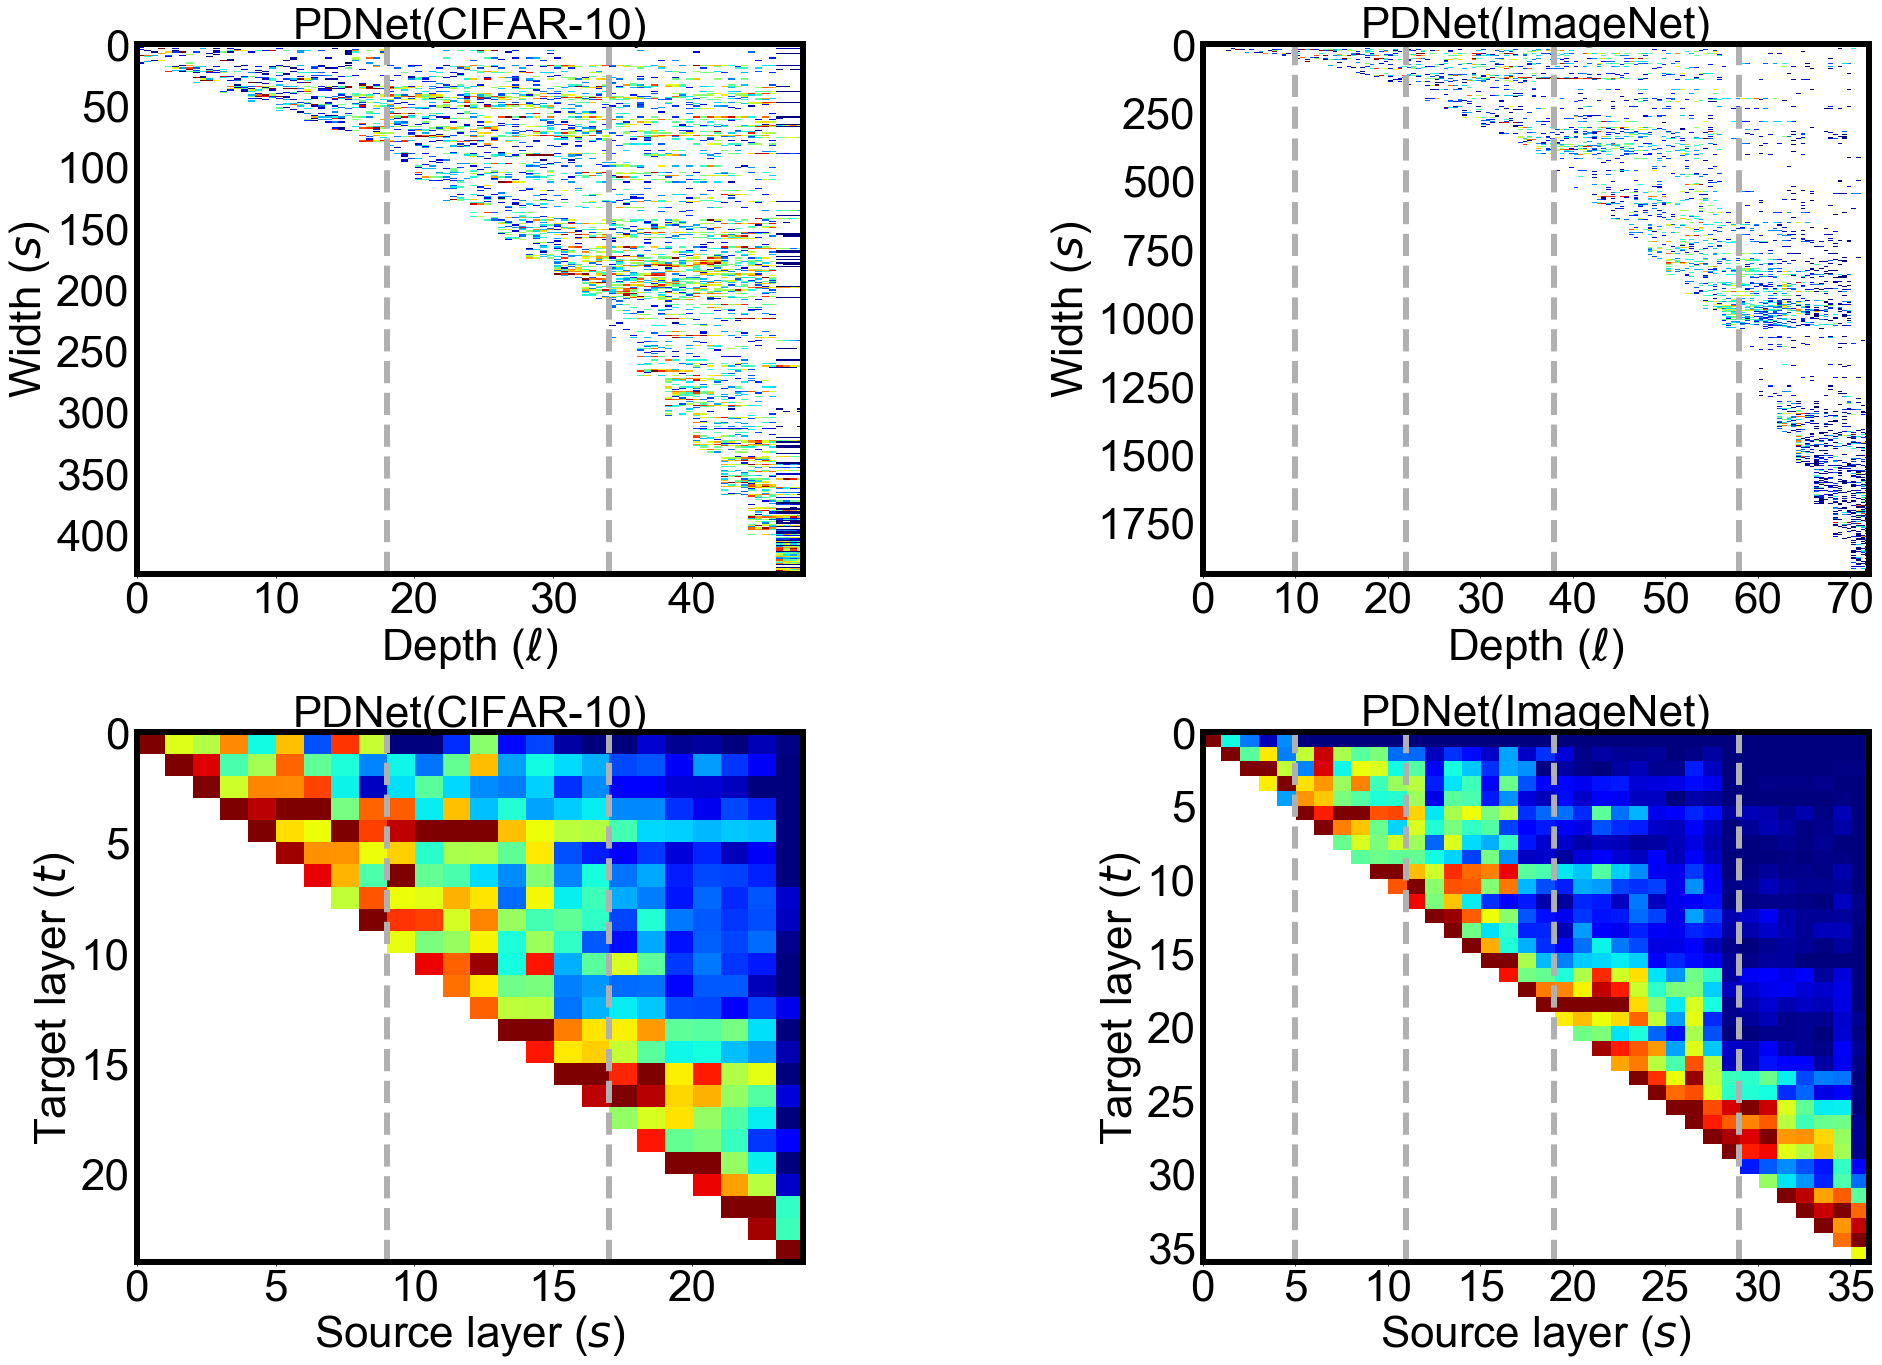

In [12]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
   
    all_masks = all_masks[::2] 
    all_weights = all_weights[::2]
    for i in range(len(all_masks)):
        all_masks[i] = all_masks[i].T
        all_weights[i] = all_weights[i].T
        
    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

    
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
#         print(conv.shape)
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = conv*mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
#     print(whole_weights)
#     print("qwer")
#     whole_weights = whole_weights[:,range(whole_weights.shape[1]-1,-1,-1)]
#     whole_weights = whole_weights[range(whole_weights.shape[0]-1,-1,-1),:]
#     whole_mask = whole_mask[:,range(whole_mask.shape[1]-1,-1,-1)]
#     whole_mask = whole_mask[range(whole_mask.shape[0]-1,-1,-1),:]
#     print(whole_weights)
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))

    im = plt.imshow(whole_weights, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
#     if random==0:
#         arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
#             head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2, 18.6*h_s, "Classification layer", 
#                 fontsize=FS*scale)  
#     else:
#         arrow = ax.arrow(20.5*2*1.5, 18*h_s*4.5, 3.2*2*1.5, 0.0, fc="k", ec="k",
#             head_width=1.*h_s*4.5, head_length=1.5*2*1.5, width=.3*h_s*4.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2*1.5, 18.6*h_s*4.5, "Classification layer", 
#                 fontsize=FS*scale) 
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
#     whole_l2l = whole_l2l[:,range(whole_l2l.shape[1]-1,-1,-1)]
#     whole_l2l = whole_l2l[range(whole_l2l.shape[0]-1,-1,-1),:]
#     whole_l2l = np.ma.masked_where(np.tril(whole_l2l+1) == 0, np.log(whole_l2l+1))
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    ### Labels
    plt.xlabel(r'Source layer ($s$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Target layer ($t$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     if random==0:
#         arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
#             head_width=1., head_length=1.5, width=.3,)
#         arrow.set_clip_on(False)
#         ax.text(6.5, 18.6, "Classification layer", 
#                 fontsize=FS*scale)
#     else:
#         arrow = ax.arrow(20.5*1.5, 18*1.5, 3.2*1.5, 0.0, fc="k", ec="k",
#             head_width=1*1.5, head_length=1.5*1.5, width=.3*1.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*1.5, 18.6*1.5, "Classification layer", 
#                 fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
#     plt.imshow(classifier, interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet', extent=[0, 1,
#                                                   whole_weights.shape[0], 0])
#     ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
#     if random==0:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
#     else:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
#     plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGCT_weight_PDNet(CIFAR-10)_PDNet(ImageNet)(exchange_sou&tar_only).pdf', bbox_inches='tight', format='pdf')

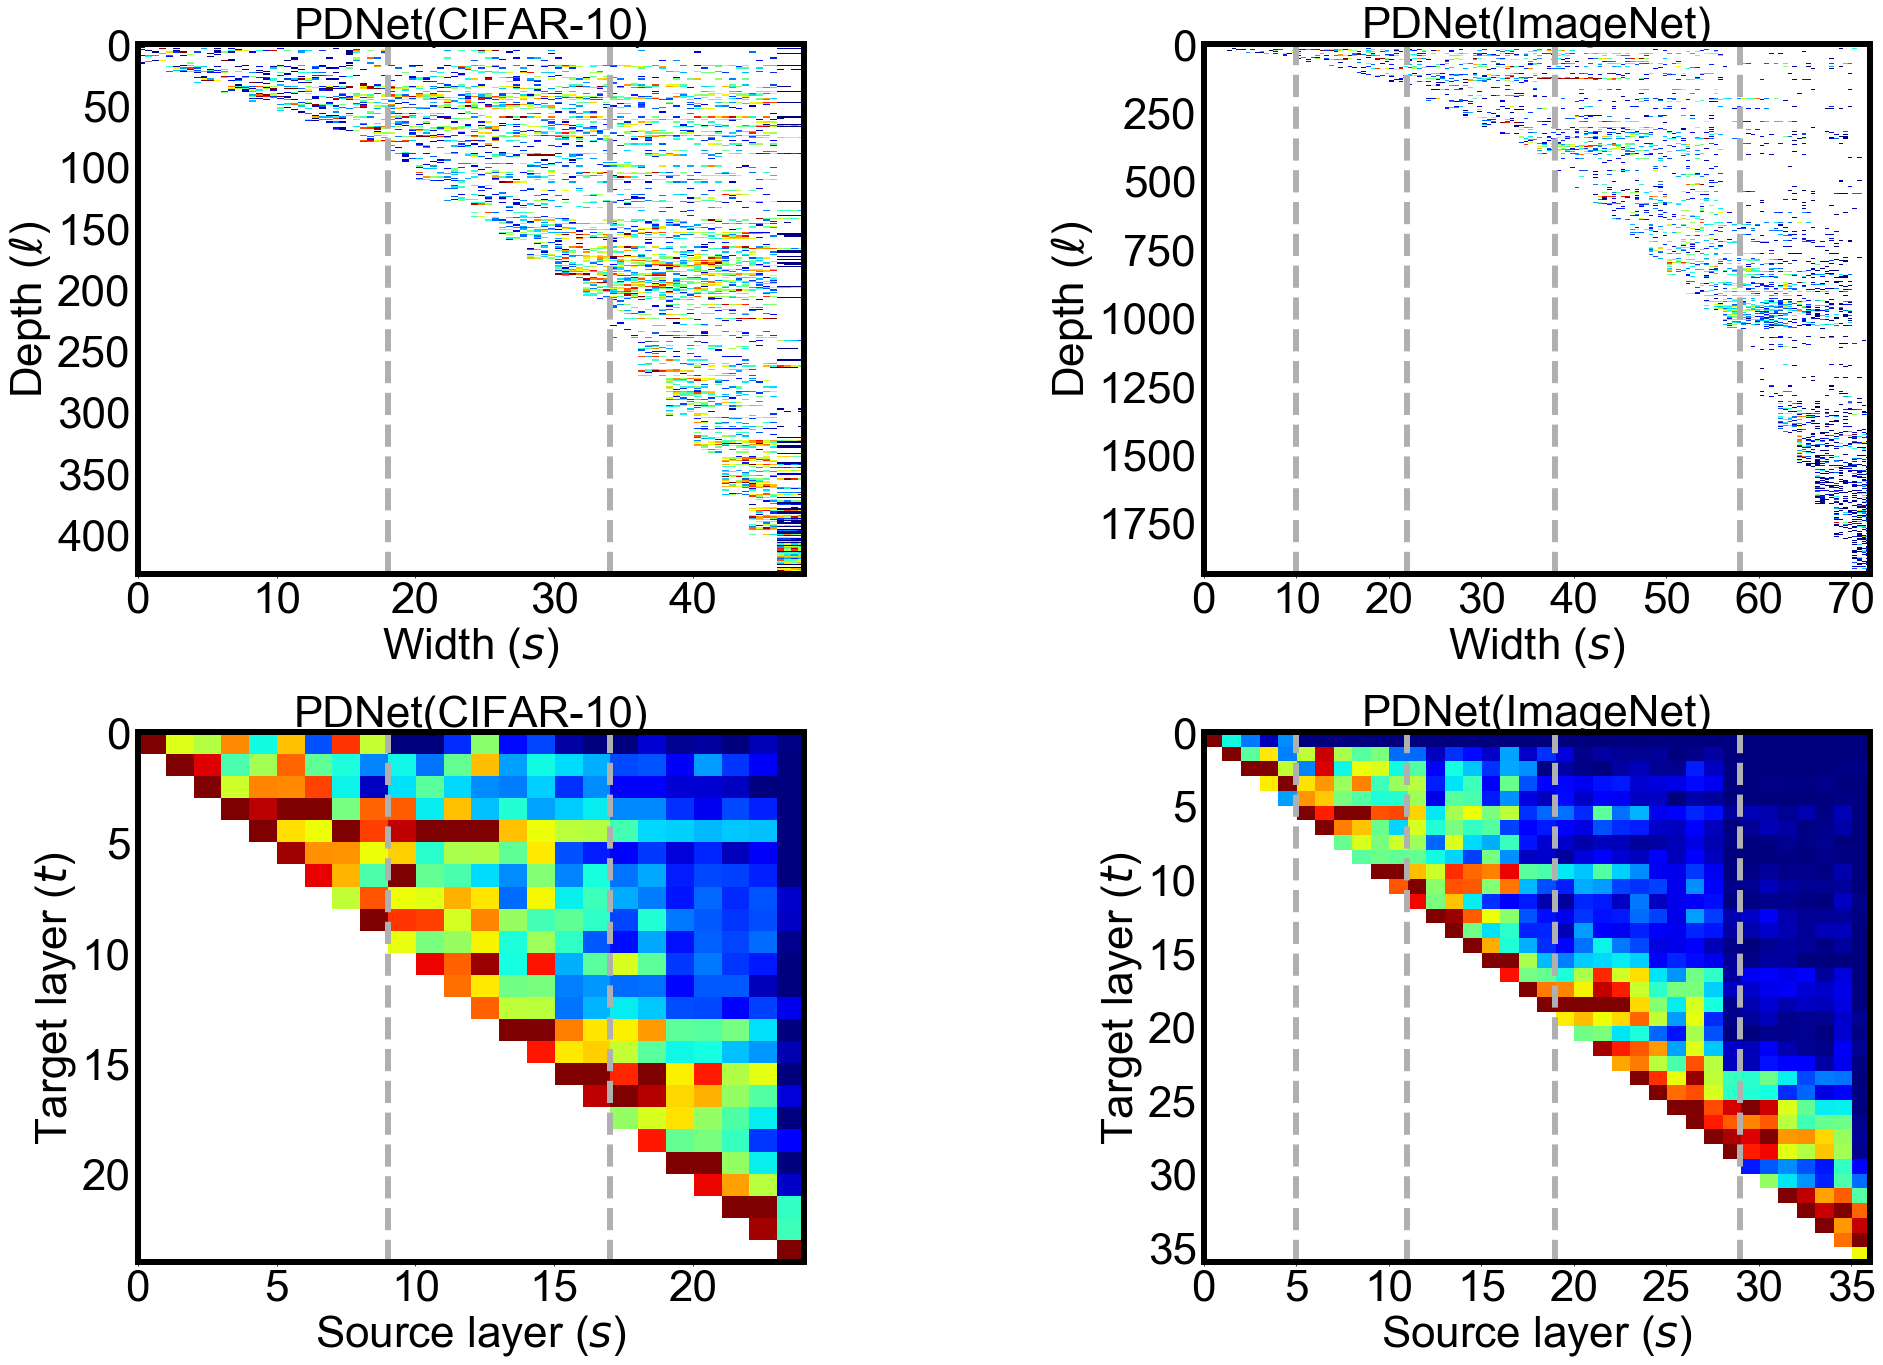

In [11]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
   
    all_masks = all_masks[::2] 
    all_weights = all_weights[::2]
    for i in range(len(all_masks)):
        all_masks[i] = all_masks[i].T
        all_weights[i] = all_weights[i].T
        
    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

    
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
#         print(conv.shape)
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = conv*mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
#     print(whole_weights)
#     print("qwer")
#     whole_weights = whole_weights[:,range(whole_weights.shape[1]-1,-1,-1)]
#     whole_weights = whole_weights[range(whole_weights.shape[0]-1,-1,-1),:]
#     whole_mask = whole_mask[:,range(whole_mask.shape[1]-1,-1,-1)]
#     whole_mask = whole_mask[range(whole_mask.shape[0]-1,-1,-1),:]
#     print(whole_weights)
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))

    im = plt.imshow(whole_weights, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Width ($s$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Depth ($\ell$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
#     if random==0:
#         arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
#             head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2, 18.6*h_s, "Classification layer", 
#                 fontsize=FS*scale)  
#     else:
#         arrow = ax.arrow(20.5*2*1.5, 18*h_s*4.5, 3.2*2*1.5, 0.0, fc="k", ec="k",
#             head_width=1.*h_s*4.5, head_length=1.5*2*1.5, width=.3*h_s*4.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2*1.5, 18.6*h_s*4.5, "Classification layer", 
#                 fontsize=FS*scale) 
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
#     whole_l2l = whole_l2l[:,range(whole_l2l.shape[1]-1,-1,-1)]
#     whole_l2l = whole_l2l[range(whole_l2l.shape[0]-1,-1,-1),:]
#     whole_l2l = np.ma.masked_where(np.tril(whole_l2l+1) == 0, np.log(whole_l2l+1))
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    ### Labels
    plt.xlabel(r'Source layer ($s$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Target layer ($t$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     if random==0:
#         arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
#             head_width=1., head_length=1.5, width=.3,)
#         arrow.set_clip_on(False)
#         ax.text(6.5, 18.6, "Classification layer", 
#                 fontsize=FS*scale)
#     else:
#         arrow = ax.arrow(20.5*1.5, 18*1.5, 3.2*1.5, 0.0, fc="k", ec="k",
#             head_width=1*1.5, head_length=1.5*1.5, width=.3*1.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*1.5, 18.6*1.5, "Classification layer", 
#                 fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
#     plt.imshow(classifier, interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet', extent=[0, 1,
#                                                   whole_weights.shape[0], 0])
#     ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
#     if random==0:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
#     else:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
#     plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGCT_weight_PDNet(CIFAR-10)_PDNet(ImageNet)(exchange_sou&tar_wid&dep).pdf', bbox_inches='tight', format='pdf')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


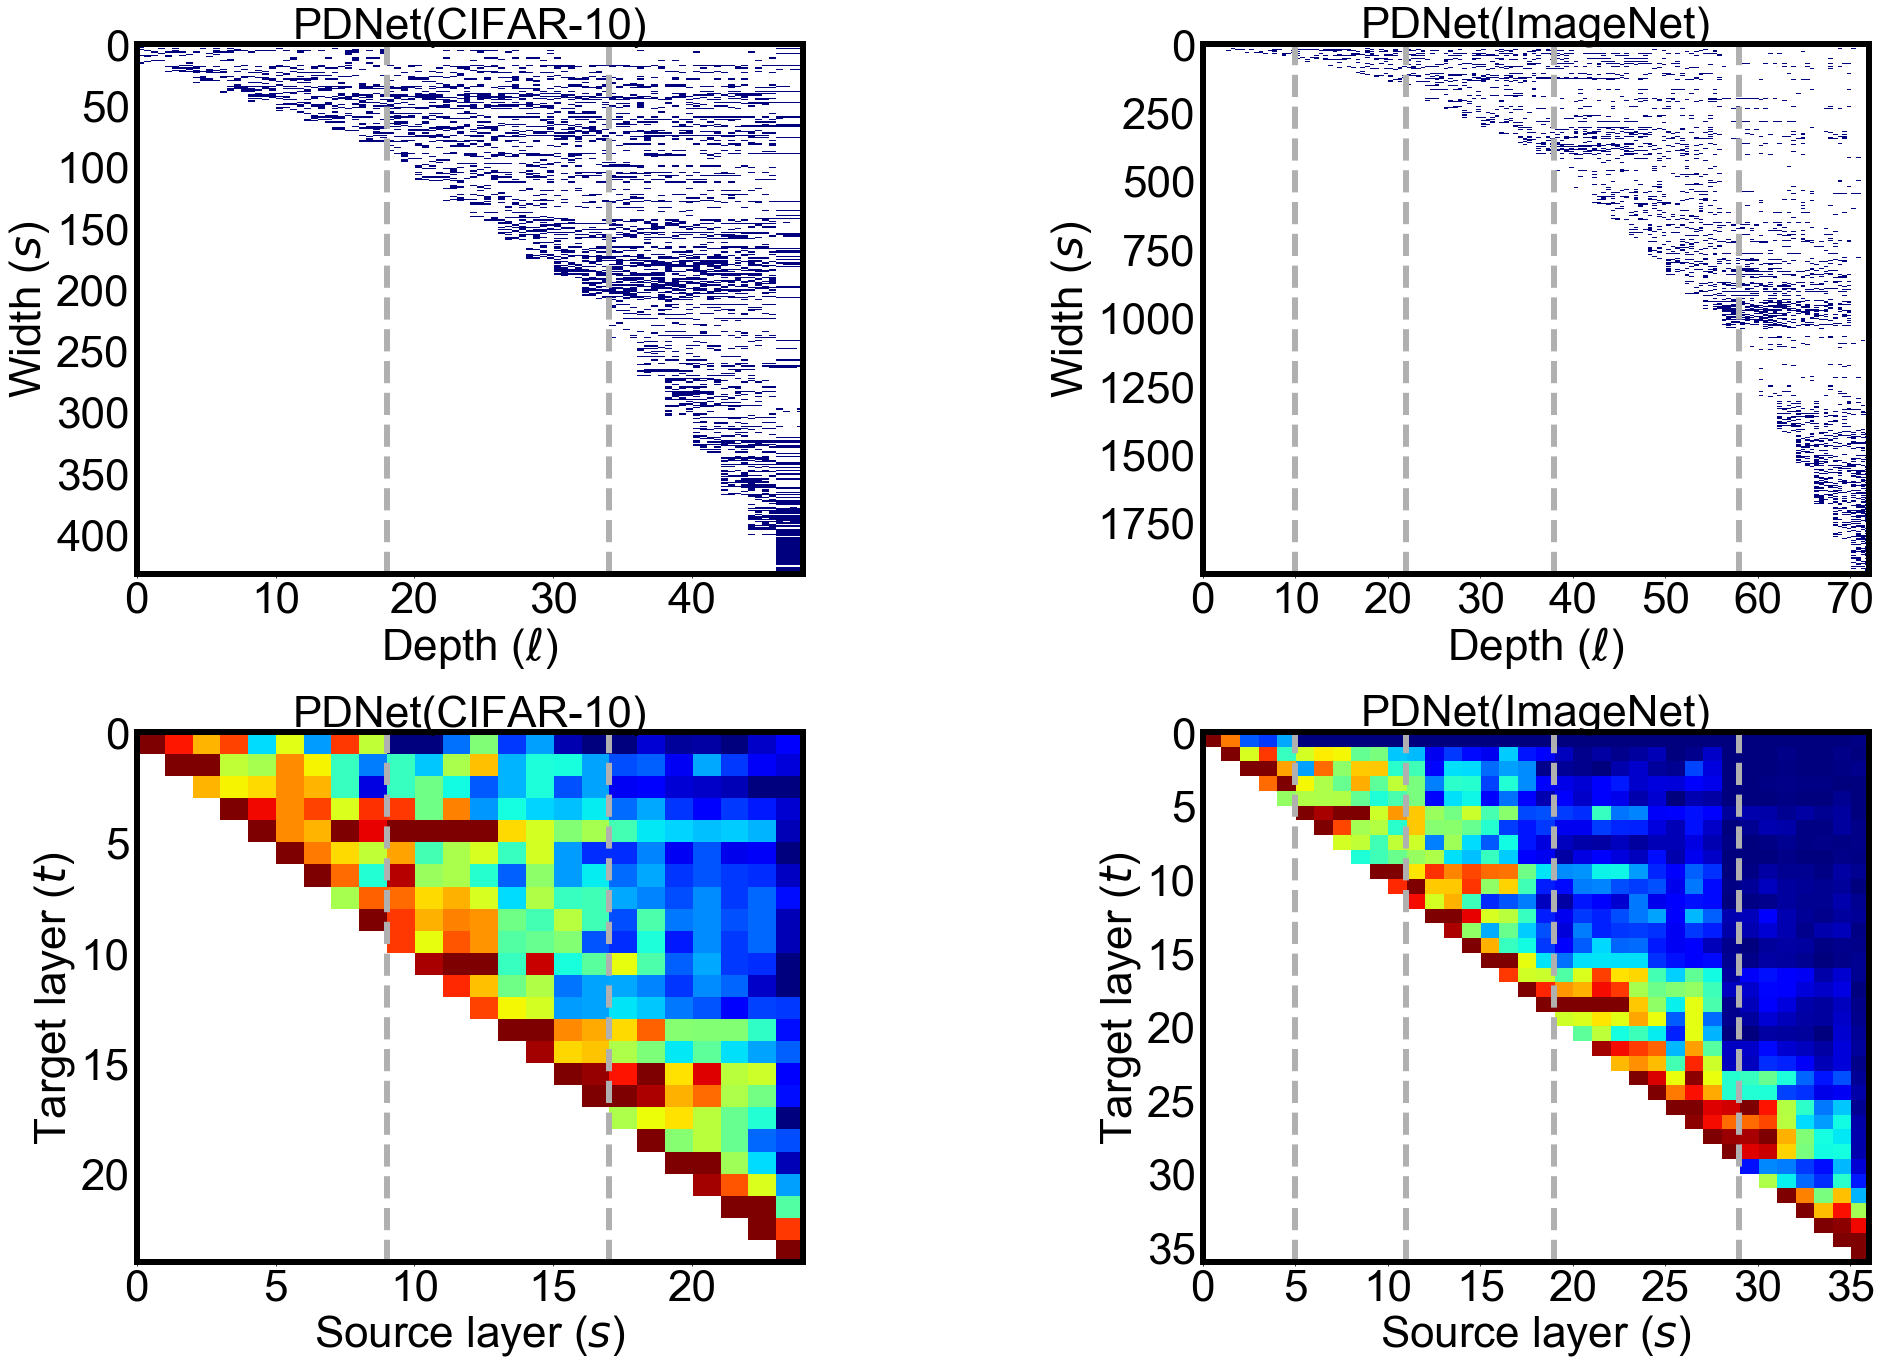

In [10]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
    print(type(all_masks[1]))
   
    all_masks = all_masks[::2] 
    all_weights = all_weights[::2]
    for i in range(len(all_masks)):
        all_masks[i] = all_masks[i].T
        all_weights[i] = all_weights[i].T
    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
#     whole_weights = whole_weights[:,range(whole_weights.shape[1]-1,-1,-1)]
#     whole_weights = whole_weights[range(whole_weights.shape[0]-1,-1,-1),:]
#     whole_mask = whole_mask[:,range(whole_mask.shape[1]-1,-1,-1)]
#     whole_mask = whole_mask[range(whole_mask.shape[0]-1,-1,-1),:]
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))
    whole_mask = np.ma.masked_where(whole_mask==0, np.log(whole_mask+1))
    im = plt.imshow(whole_mask, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    
    ### Labels
    plt.xlabel(r'Depth ($\ell$)', size=FS*scale)
#     if random == 0:
    plt.ylabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
#     if random==0:
#         arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
#             head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2, 18.6*h_s, "Classification layer", 
#                 fontsize=FS*scale)  
#     else:
#         arrow = ax.arrow(20.5*2*1.5, 18*h_s*4.5, 3.2*2*1.5, 0.0, fc="k", ec="k",
#             head_width=1.*h_s*4.5, head_length=1.5*2*1.5, width=.3*h_s*4.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2*1.5, 18.6*h_s*4.5, "Classification layer", 
#                 fontsize=FS*scale) 
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
#     whole_l2l = whole_l2l[:,range(whole_l2l.shape[1]-1,-1,-1)]
#     whole_l2l = whole_l2l[range(whole_l2l.shape[0]-1,-1,-1),:]
#     whole_l2l = np.ma.masked_where(np.tril(whole_l2l+1) == 0, np.log(whole_l2l+1))
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    ### Labels
    plt.ylabel(r'Target layer ($t$)', size=FS*scale)
#     if random == 0:
    plt.xlabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     if random==0:
#         arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
#             head_width=1., head_length=1.5, width=.3,)
#         arrow.set_clip_on(False)
#         ax.text(6.5, 18.6, "Classification layer", 
#                 fontsize=FS*scale)
#     else:
#         arrow = ax.arrow(20.5*1.5, 18*1.5, 3.2*1.5, 0.0, fc="k", ec="k",
#             head_width=1*1.5, head_length=1.5*1.5, width=.3*1.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*1.5, 18.6*1.5, "Classification layer", 
#                 fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
#     plt.imshow(classifier, interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet', extent=[0, 1,
#                                                   whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
#     if random==0:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
#     else:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
#     plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGCT_mask_PDNet(CIFAR-10)_PDNet(ImageNet)(exchange_sou&tar_only).pdf', bbox_inches='tight', format='pdf')

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


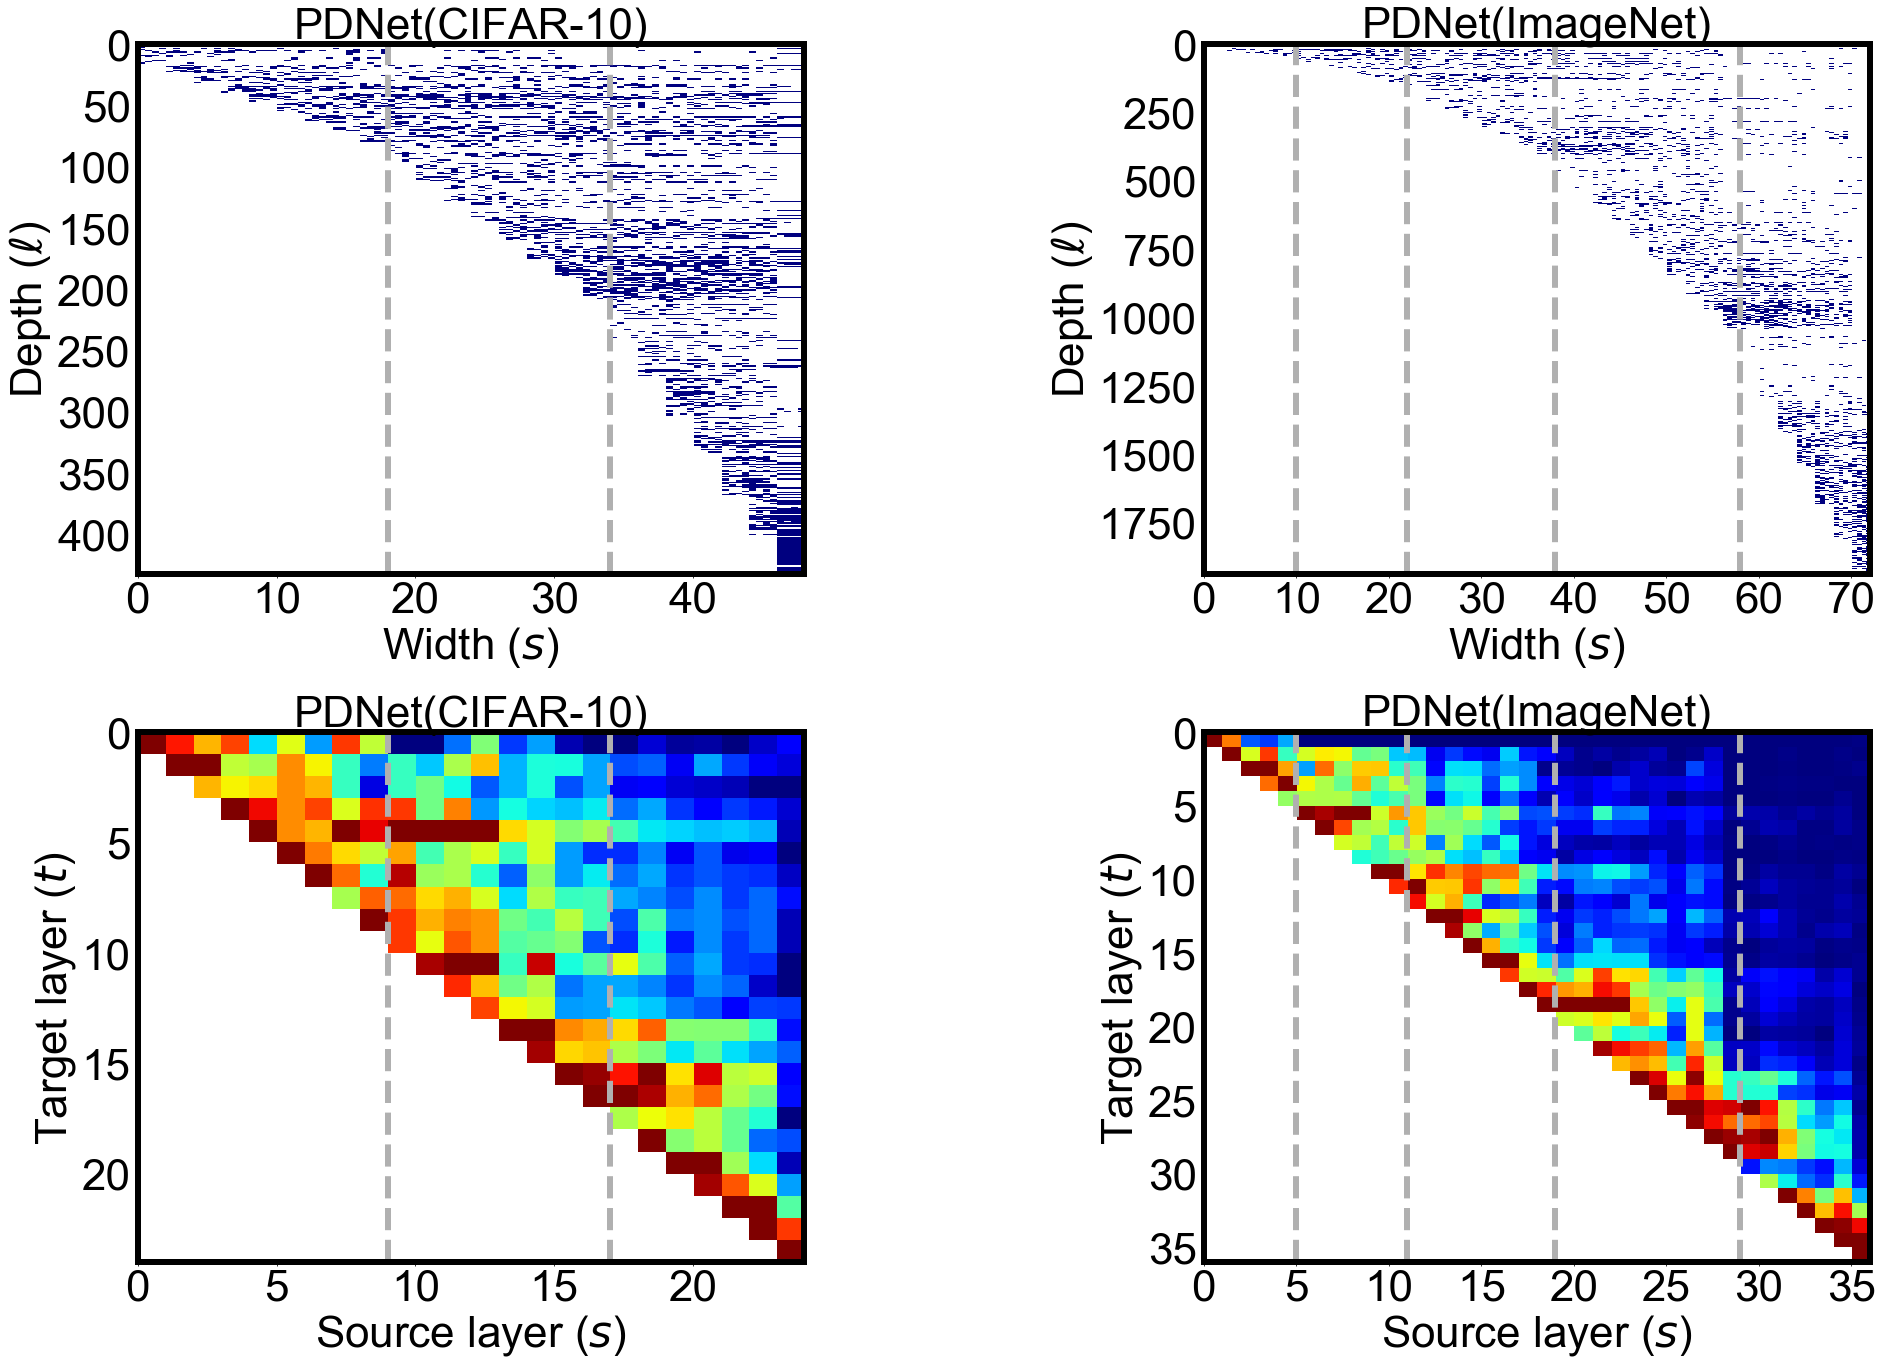

In [9]:
%matplotlib inline
import torch
import numpy as np
import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plt.switch_backend('agg')

from matplotlib import rcParams
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

HOME = '/home/gh349/denseNet/densenet_pytorch/results/cifar10_final_plot_var/'
groups = 4



scale = 4
balance = 34
fig = plt.figure(figsize=(8*scale, 5.6*scale))

FS = 11

TOTAL = 2
HEIGHT = 2

for random in range(TOTAL):
    if random == 0:
        model = torch.load(r'condenserestrans52\save_models\model_best.pth.tar')['state_dict']
    elif random == 1:
        model = torch.load(r'model_best.pth.tar')['state_dict']
    else:
        model = torch.load(r'modi\40_threshold20condensenet\save_models\model_best.pth.tar')['state_dict']
    all_masks = []
    all_weights = []
    for mask in model.keys():
        if mask.endswith("mask"):
            conv = '.'.join(mask.split('.')[:-1])+'.conv.weight'
            all_masks.append(model[mask].squeeze().cpu().numpy())
            all_weights.append(model[conv].abs().squeeze().cpu().numpy())
    classifier = model["module.classifier.weight"].abs().cpu().numpy().sum(0)
    classifier = classifier.reshape([-1, 1])
    all_masks.reverse()
    all_weights.reverse()
    print(type(all_masks[1]))
   
    all_masks = all_masks[::2] 
    all_weights = all_weights[::2]
    for i in range(len(all_masks)):
        all_masks[i] = all_masks[i].T
        all_weights[i] = all_weights[i].T
    whole_mask = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_weights = np.zeros([len(all_masks)*groups, all_masks[0].shape[1]])
    whole_l2l = np.zeros([len(all_masks), len(all_masks)])
    start, delta, last = 0, 0, 0
    x_grids = []
    classifier_blocks = []
    growth_rates = [0]
    mark = 0
    for conv, mask in zip(all_weights, all_masks):
        whole_mask[start:start+groups, :mask.shape[1]] = mask[:groups]
        weight = conv.reshape([groups, conv.shape[0]//groups, conv.shape[1]]).sum(1)
        up = (weight-np.min(weight, axis=1).reshape([-1, 1]))
        down = (np.max(weight, axis=1).reshape([-1, 1])-np.min(weight, axis=1).reshape([-1, 1]))
        whole_weights[start:start+groups, :mask.shape[1]] = up/down
        i = start // groups
        if i > 0:
            if all_masks[i].shape[1]-last != delta:
                if i > 1:
                    x_grids.append(whole_mask.shape[0]//groups - i + 1)
                delta = all_masks[i].shape[1]-last
            classifier_blocks.append(np.abs(classifier[all_masks[i].shape[1]:last]).sum())
        last = all_masks[i].shape[1]
        start += groups
    classifier_blocks.reverse()

        
    for i in reversed(range(len(all_weights))):
        conv = all_weights[i]
        mask = all_masks[i]
        growth_rates.append(all_masks[i].shape[1])
        for j in range(1, len(all_weights)-i+1):
            masked = mask
            masked = masked.reshape([groups, masked.shape[0]//groups, masked.shape[1]]).sum(1).sum(0)
            whole_l2l[i, j-1] = masked[growth_rates[j-1]:growth_rates[j]].sum()
        up = (whole_l2l[i]-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        down = (np.max(whole_l2l[i].reshape([1, -1]), axis=1)-np.min(whole_l2l[i].reshape([1, -1]), axis=1)).reshape([1, -1])
        whole_l2l[i] = up / down
        

    whole_mask = np.rot90(whole_mask, 3)
    whole_weights = np.rot90(whole_weights, 3)
    whole_l2l = np.rot90(whole_l2l, 3)
#     whole_weights = whole_weights[:,range(whole_weights.shape[1]-1,-1,-1)]
#     whole_weights = whole_weights[range(whole_weights.shape[0]-1,-1,-1),:]
#     whole_mask = whole_mask[:,range(whole_mask.shape[1]-1,-1,-1)]
#     whole_mask = whole_mask[range(whole_mask.shape[0]-1,-1,-1),:]
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    whole_weights = np.ma.masked_where(whole_mask==0, np.log(whole_weights+1))
    whole_mask = np.ma.masked_where(whole_mask==0, np.log(whole_mask+1))
    im = plt.imshow(whole_mask, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1]//groups*2,
                                                       whole_weights.shape[0], 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    
    ### Labels
    plt.ylabel(r'Depth ($\ell$)', size=FS*scale)
#     if random == 0:
    plt.xlabel(r'Width ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(np.array(x_grids)*2, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     h_s = 17
#     arrow = ax.arrow(30.4, 20*h_s, 17, 0.0, fc="k", ec="k",
#         head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#     arrow.set_clip_on(False)
#     ax.text(11, 20.6*h_s, "Classifier", 
#             fontsize=10*scale)
    h_s = 432/26.
#     if random==0:
#         arrow = ax.arrow(20.5*2, 18*h_s, 3.2*2, 0.0, fc="k", ec="k",
#             head_width=1.*h_s, head_length=1.5*2, width=.3*h_s,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2, 18.6*h_s, "Classification layer", 
#                 fontsize=FS*scale)  
#     else:
#         arrow = ax.arrow(20.5*2*1.5, 18*h_s*4.5, 3.2*2*1.5, 0.0, fc="k", ec="k",
#             head_width=1.*h_s*4.5, head_length=1.5*2*1.5, width=.3*h_s*4.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*2*1.5, 18.6*h_s*4.5, "Classification layer", 
#                 fontsize=FS*scale) 
    ################
    #
    ################
    whole_l2l = np.ma.masked_where(np.triu(whole_l2l+1) == 0, np.log(whole_l2l+1))
#     whole_l2l = whole_l2l[:,range(whole_l2l.shape[1]-1,-1,-1)]
#     whole_l2l = whole_l2l[range(whole_l2l.shape[0]-1,-1,-1),:]
#     whole_l2l = np.ma.masked_where(np.tril(whole_l2l+1) == 0, np.log(whole_l2l+1))
    if random == 0:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance+5)//TOTAL+1) * random), colspan=(balance-7)//TOTAL)
    im = plt.imshow(whole_l2l, interpolation="nearest", origin="upper", 
                    aspect='auto', cmap='jet', extent=[0, whole_weights.shape[1] // groups,
                                                       whole_weights.shape[1] // groups, 0])

    ### Ticklabels
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(FS*scale)
#     if random != 0:
#         ax.axes.get_yaxis().set_visible(False)
        
    ### Title
#     plt.title(r'Model (%d)'%(random+1), size=FS*scale)
    if random == 0:
        plt.title(r'PDNet(CIFAR-10)', size=FS*scale)
    else:
        plt.title(r'PDNet(ImageNet)', size=FS*scale)
    ### Labels
    plt.ylabel(r'Target layer ($t$)', size=FS*scale)
#     if random == 0:
    plt.xlabel(r'Source layer ($s$)', size=FS*scale)

    ### Grid
    ax.set_xticks(x_grids, minor=True)
    ax.xaxis.grid(True, which='minor', linestyle='--', linewidth=1.5*scale)

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
    ### Text
#     if random==0:
#         arrow = ax.arrow(20.5, 18, 3.2, 0.0, fc="k", ec="k",
#             head_width=1., head_length=1.5, width=.3,)
#         arrow.set_clip_on(False)
#         ax.text(6.5, 18.6, "Classification layer", 
#                 fontsize=FS*scale)
#     else:
#         arrow = ax.arrow(20.5*1.5, 18*1.5, 3.2*1.5, 0.0, fc="k", ec="k",
#             head_width=1*1.5, head_length=1.5*1.5, width=.3*1.5,)
#         arrow.set_clip_on(False)
#         ax.text(6.5*1.5, 18.6*1.5, "Classification layer", 
#                 fontsize=FS*scale)


    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
    if random==0:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
    else:
        ax = plt.subplot2grid((HEIGHT, balance), (0, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
        ax.set_visible(False)
#     plt.imshow(classifier, interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet', extent=[0, 1,
#                                                   whole_weights.shape[0], 0])
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)
        
#     print(classifier, np.array(classifier_blocks).reshape([-1, 1]))
    ################
    ### Classifer
    #################
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=0.3)
#     if random==0:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-7)//TOTAL+1)*(random+1)-1), colspan=1)
#     else:
#         ax = plt.subplot2grid((HEIGHT, balance), (1, ((balance-1)//TOTAL+1)*(random+1)-1), colspan=1)
#     plt.imshow(np.array(classifier_blocks).reshape([-1, 1]), interpolation="nearest", origin="upper", 
#                aspect='auto', cmap='jet')
    ### Ticks
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    ### Border
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5*scale)

plt.show()
fig.savefig('mask&weight\LGCT_mask_PDNet(CIFAR-10)_PDNet(ImageNet)(exchange_sou&tar_wid&dep).pdf', bbox_inches='tight', format='pdf')